# Detecting network intrusions & anomalies with higher-order topological kernels via quantum computation 

### 0. CONSTRUCTING NUMPY DATASETS

In [95]:
import pandas as pd
import numpy as np

# Load the CSV from big dataset
filename = 'BCCC-CIC-CSE-IDS2018/Friday-02-03-2018/friday_02_03_2018_bot/friday_02_03_2018_bot.csv'

# Load the first 50 rows
df = pd.read_csv(filename, nrows=500)

# Select the top 5 anomaly-related features
selected_features = [
    'total_payload_bytes',
    'bytes_rate',
    'packets_rate',
    'avg_segment_size',
    'duration',
    'fwd_bytes_rate',
    'bwd_bytes_rate',
    'syn_flag_counts'

]

# Extract the relevant features
features_df = df[selected_features]

# # Save as CSV
# features_df.to_csv('CSV-500-botnet-benign.csv', index=False)

# Save as a NumPy array
features_array = features_df.to_numpy()
np.save('500-botnet-attack.npy', features_array)


## BEGIN - TRAINING VECTORS & LOAD DATA

In [1]:
from sklearn.svm import SVC
from sklearn.model_selection import train_test_split
import numpy as np
from quask.core import Ansatz, Kernel, KernelFactory, KernelType

from quask.core_implementation import QiskitKernel

In [2]:
# import pandas as pd
# from sklearn.preprocessing import MinMaxScaler

# # Specify the columns you want to load
# # cols = ["duration", "packets_rate", "total_payload_bytes", "syn_flag_counts", "avg_segment_size", "fwd_bytes_rate", "bwd_bytes_rate", "ack_flag_counts", "fwd_avg_segment_size", "packets_count", "bytes_rate", "avg_fwd_bytes_per_bulk", "idle_mean", "fwd_packets_IAT_mean", "payload_bytes_variance"]

# # 8
# cols = ["duration", "packets_rate", "total_payload_bytes", "bytes_rate", "syn_flag_counts", "avg_segment_size", "fwd_bytes_rate", "bwd_bytes_rate"]

# # 11
# # cols = ['src_port', 'duration', 'bytes_rate', 'packets_IAT_cov', 'packets_IAT_variance', 'fwd_packets_IAT_median', 'bwd_packets_IAT_std', 'bwd_packets_IAT_variance', 'min_bwd_packets_delta_time', 'mode_packets_delta_time', 'median_bwd_packets_delta_time']

# # 10
# # cols = ['src_port', 'duration', 'bytes_rate', 'packets_IAT_cov', 'packets_IAT_variance', 'fwd_packets_IAT_median', 'bwd_packets_IAT_std', 'min_bwd_packets_delta_time', 'mode_packets_delta_time', 'median_bwd_packets_delta_time']

# # 18
# # cols = ['src_port', 'duration', 'payload_bytes_max', 'payload_bytes_std',
# #        'fwd_payload_bytes_variance', 'bwd_median_header_bytes', 'down_up_rate',
# #        'avg_bwd_bytes_per_bulk', 'packet_IAT_min', 'fwd_packets_IAT_min',
# #        'fwd_packets_IAT_mode', 'max_bwd_packets_delta_time',
# #        'mean_bwd_packets_delta_time', 'variance_bwd_packets_delta_time',
# #        'cov_bwd_packets_delta_time', 'skewness_fwd_packets_delta_time',
# #        'mode_bwd_packets_delta_len', 'mode_fwd_packets_delta_len']

# # Load only the first 200 rows and selected columns
# qX1 = pd.read_csv(
#     'BCCC-CIC-CSE-IDS2018/Friday-23-02-2018/friday_23_02_2018_benign/friday_23_02_2018_benign.csv',
#     usecols=cols,
#     nrows=30
# ).to_numpy()

# qX2 = pd.read_csv(
#     'BCCC-CIC-CSE-IDS2018/Friday-23-02-2018/friday_23_02_2018_BF_web/friday_23_02_2018_BF_web.csv',
#     usecols=cols,
#     nrows=30
# ).to_numpy()


# # Transform separately
# # scaler = MinMaxScaler(feature_range=(-1, 1))
# # scaler.fit(np.vstack([qX1, qX2]))

# # qX1 = scaler.transform(qX1)
# # qX2 = scaler.transform(qX2)


In [3]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import MinMaxScaler
import xgboost as xgb

# --- Load ---
df_attack = pd.read_csv(
    'BCCC-CIC-CSE-IDS2018/Friday-16-02-2018/friday_16_02_2018_dos_hulk_part2/friday_16_02_2018_dos_hulk_part2.csv',
    nrows=50
)
df_benign = pd.read_csv(
    'BCCC-CIC-CSE-IDS2018/Friday-16-02-2018/friday_16_02_2018_benign_part2/friday_16_02_2018_benign_part2.csv',
    nrows=50
)

# --- Keep numeric columns ---
X_attack = df_attack.select_dtypes(include=[np.number]).copy()
X_benign = df_benign.select_dtypes(include=[np.number]).copy()

# --- Replace inf with NaN ---
X_attack.replace([np.inf, -np.inf], np.nan, inplace=True)
X_benign.replace([np.inf, -np.inf], np.nan, inplace=True)

# --- Drop columns with >20% missing in attack ---
miss_thresh = 0.2
good_cols = X_attack.isnull().mean() < miss_thresh
X_attack = X_attack.loc[:, good_cols]
X_benign = X_benign.loc[:, good_cols]

# --- Drop single-value columns (attack) ---
multi_cols = X_attack.nunique()[X_attack.nunique() > 1].index
shared_cols = [col for col in multi_cols if col in X_benign.columns]
X_attack = X_attack[shared_cols]
X_benign = X_benign[shared_cols]

# --- Drop highly collinear columns (corr > 0.95) ---
corr = X_attack.corr().abs()
upper = corr.where(np.triu(np.ones(corr.shape), k=1).astype(bool))
to_drop = [col for col in upper.columns if any(upper[col] > 0.95)]
X_attack = X_attack.drop(columns=to_drop)
X_benign = X_benign.drop(columns=to_drop)

# --- Drop any column from benign that still has NaNs ---
no_nan_cols = X_benign.columns[~X_benign.isnull().any()]
X_attack = X_attack[no_nan_cols]
X_benign = X_benign[no_nan_cols]


qX1 = X_benign
qX2 = X_attack

qX1 = qX1.loc[~(qX1 == 0.0).all(axis=1)]
qX2 = qX2.loc[~(qX2 == 0.0).all(axis=1)]
# 1. Combine and label
X = pd.concat([qX1, qX2], axis=0)
y = np.array([0] * len(qX1) + [1] * len(qX2))  # 0 = benign, 1 = attack

# 2. Train an XGBoost classifier
model = xgb.XGBClassifier(
    use_label_encoder=False,
    eval_metric='logloss',  # suppress warning
    n_estimators=100,
    max_depth=4,
    learning_rate=0.1,
    random_state=42
)
model.fit(X, y)

# 3. Get feature importances and pick top 10
importances = pd.Series(model.feature_importances_, index=X.columns)
top_features = importances.nlargest(8).index.tolist()
print("Top-10 features by importance:")
for i, feat in enumerate(top_features, 1):
    print(f"{i}. {feat} ({importances[feat]:.4f})")

# 4. Re-slice your datasets to only those top features
qX1 = qX1[top_features].copy()
qX2 = qX2[top_features].copy()

print("\nAfter selecting top features:")
# print("Benign shape:", qX1_top.shape)
# print("Attack shape:", qX2_top.shape)
# --- Normalize to [-1, 1] ---
# scaler = MinMaxScaler(feature_range=(-1, 1))
# combined_scaled = pd.concat([qX1, qX2])
# scaler.fit(combined_scaled)

# qX1 = pd.DataFrame(scaler.transform(qX1), columns=top_features)
# qX2 = pd.DataFrame(scaler.transform(qX2), columns=top_features)

# --- Final Output ---
print("Final selected features:", qX2.columns)
print("Benign shape:", qX1.shape)
print("Attack shape:", qX2.shape)


/mnt/c/users/maryc/onedrive/desktop/Quantum Research 2025/.venv/lib/python3.10/site-packages/xgboost/training.py:183: UserWarning: [23:39:47] WARNING: /workspace/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


Top-10 features by importance:
1. dst_port (1.0000)
2. duration (0.0000)
3. packets_count (0.0000)
4. fwd_packets_count (0.0000)
5. bwd_packets_count (0.0000)
6. total_payload_bytes (0.0000)
7. payload_bytes_mean (0.0000)
8. payload_bytes_std (0.0000)

After selecting top features:
Final selected features: Index(['dst_port', 'duration', 'packets_count', 'fwd_packets_count',
       'bwd_packets_count', 'total_payload_bytes', 'payload_bytes_mean',
       'payload_bytes_std'],
      dtype='object')
Benign shape: (50, 8)
Attack shape: (50, 8)


In [4]:
# qX1 = np.load('ATTACKDATA/loicbenign_200.npy', allow_pickle=True)
# qX2 = np.load('ATTACKDATA/loicattack_200.npy', allow_pickle=True)

In [5]:
# columns = [3, 4, 5, 6, 7, 8, 9, 10]
# qX1 = qX1[:15,columns]
# qX2 = qX2[:15,columns]

In [6]:
qX = np.row_stack([qX1, qX2])
qy = np.array([-1] * len(qX1) + [1] * len(qX2))

print(f"{qX.shape=}")
print(f"{qy.shape=}")

qX.shape=(100, 8)
qy.shape=(100,)


In [7]:
qX_train, qX_test, qy_train, qy_test = train_test_split(qX, qy, test_size=0.2, random_state=42)

print("Shape training set:", qX_train.shape, qy_train.shape)
print("Shape testing set:", qX_test.shape, qy_test.shape)
print("Example of feature:", qX_train[0])
print("Example of label:", qy_train[0])

Shape training set: (80, 8) (80,)
Shape testing set: (20, 8) (20,)
Example of feature: [4.29720000e+04 4.63145018e+00 1.00000000e+01 5.00000000e+00
 5.00000000e+00 1.26900000e+03 1.26900000e+02 2.87183700e+02]
Example of label: 1


In [8]:
# Instantiate a machine learning model
model = SVC(kernel='precomputed')

## BUILD QUANTUM KERNEL

In [9]:
from quask.core_implementation.qiskit_kernel import QiskitKernel
from quask.core import KernelType
from qiskit_ibm_runtime import QiskitRuntimeService, Session, Sampler

# SIMULATED AER BACKEND
def create_qiskit_noiseless(ansatz, measurement: str, type: KernelType):
    # Here platform="infty_shots" forces Estimator/Aer path inside QiskitKernel
    return QiskitKernel(
        ansatz,
        measurement,
        type,
        platform="infty_shots",
        n_shots=None  # None means no sampling, use statevector/estimator
    )

# REAL QUANTUM BACKEND
_service = QiskitRuntimeService(name="cotrum")
backend = _service.backend("ibm_rensselaer")
options = {
    "dynamical_decoupling": {"sequence_type": "XX", "enable": False},
    "twirling": {"enable_gates": False, "enable_measure": False, "num_randomizations": "auto", "shots_per_randomization": "auto"}
}

# Example factory for a real IBM backend with given options
def create_qiskit_ibm(ansatz, measurement: str, type: KernelType):
    return QiskitKernel(
        ansatz,
        measurement,
        type,
        platform="ibm_quantum",    # or leave default so QiskitKernel picks job mode
        n_shots=2048,
        options=options,
        backend=backend,
    )

Add to Factory

In [10]:
from quask.core import KernelFactory, Ansatz

# Register the noiseless factory
# KernelFactory.add_implementation('qiskit_noiseless', create_qiskit_noiseless)
# Register the IBM backend factory
KernelFactory.add_implementation('qiskit_ibm', create_qiskit_ibm)

# Choose which one is the default for create_kernel calls:
# KernelFactory.set_current_implementation('qiskit_noiseless')
# ...later, if you want to switch:
KernelFactory.set_current_implementation('qiskit_ibm')

Define ansatz ops

In [11]:
ansatz = Ansatz(n_features=8, n_qubits=4, n_operations=8)
ansatz.initialize_to_identity()
# e.g. set operations...
ansatz.change_operation(0, new_feature=0, new_wires=[0, 1], new_generator="XX", new_bandwidth=0.1)
ansatz.change_operation(1, new_feature=1, new_wires=[1, 2], new_generator="XY", new_bandwidth=0.1)
ansatz.change_operation(2, new_feature=2, new_wires=[2, 3], new_generator="XZ", new_bandwidth=0.1)
ansatz.change_operation(3, new_feature=3, new_wires=[3, 0], new_generator="YX", new_bandwidth=0.1)
ansatz.change_operation(4, new_feature=4, new_wires=[0, 1], new_generator="YY", new_bandwidth=0.1)
ansatz.change_operation(5, new_feature=5, new_wires=[1, 2], new_generator="YZ", new_bandwidth=0.1)
ansatz.change_operation(6, new_feature=6, new_wires=[2, 3], new_generator="ZX", new_bandwidth=0.1)
ansatz.change_operation(7, new_feature=7, new_wires=[3, 0], new_generator="ZY", new_bandwidth=0.1)
# 8
# ansatz.change_operation(8, new_feature=8, new_wires=[0, 1], new_generator="XX", new_bandwidth=0.1)
# ansatz.change_operation(9, new_feature=9, new_wires=[1, 2], new_generator="XY", new_bandwidth=0.1)
# ansatz.change_operation(10, new_feature=10, new_wires=[2, 3], new_generator="XZ", new_bandwidth=0.1)
# ansatz.change_operation(11, new_feature=11, new_wires=[3, 0], new_generator="YX", new_bandwidth=0.1)
# ansatz.change_operation(12, new_feature=12, new_wires=[0, 1], new_generator="YY", new_bandwidth=0.1)
# ansatz.change_operation(13, new_feature=13, new_wires=[1, 2], new_generator="YZ", new_bandwidth=0.1)
# ansatz.change_operation(14, new_feature=14, new_wires=[2, 3], new_generator="ZX", new_bandwidth=0.1)
# # 20
# ansatz.change_operation(15, new_feature=15, new_wires=[3, 0], new_generator="ZY", new_bandwidth=0.1)
# ansatz.change_operation(16, new_feature=16, new_wires=[0, 1], new_generator="XX", new_bandwidth=0.1)
# ansatz.change_operation(17, new_feature=17, new_wires=[1, 2], new_generator="XY", new_bandwidth=0.1)
# ansatz.change_operation(18, new_feature=18, new_wires=[2, 3], new_generator="XZ", new_bandwidth=0.1)
# ansatz.change_operation(19, new_feature=19, new_wires=[3, 0], new_generator="YX", new_bandwidth=0.1)


Create KernelFactory

In [12]:
kernel = KernelFactory.create_kernel(ansatz, "ZZZZ", KernelType.FIDELITY)

kernel.service = _service # This will invoke whichever implementation is current (e.g., create_qiskit_noiseless).

Set up a Session

In [13]:
# batch all jobs in a session
# with Session(backend=backend) as session:
#     kernel._session = session
#     kernel._sampler = Sampler(session=session)

#     K_train = kernel.build_kernel(X_train, X_train, matrix="train")


K_train = kernel.build_kernel(qX_train, qX_train, matrix="train") # train data
np.set_printoptions(threshold=np.inf)
print(K_train)

Number of circuits (isa_circuits):  3160
Job sent to hardware. Job ID: d1jkri4uvp6s73c7pno0
Job sent to hardware. Job ID: d1jkt9n29o4s73ancnv0
Job sent to hardware. Job ID: d1jkuvv29o4s73ancpug
Job sent to hardware. Job ID: d1jl0mfa572c73950rcg
Job sent to hardware. Job ID: d1jl2dkuvp6s73c7q0rg
Job sent to hardware. Job ID: d1jl43cuvp6s73c7q3l0
Job sent to hardware. Job ID: d1jl5osuvp6s73c7q5t0
Job sent to hardware. Job ID: d1jl7eva572c739515k0
Job sent to hardware. Job ID: d1jl94n29o4s73and8g0
Job sent to hardware. Job ID: d1jlaqb9fb3c73efafe0
Job sent to hardware. Job ID: d1jlcgr9fb3c73efai10
Job sent to hardware. Job ID: d1jle739fb3c73efakfg
Job sent to hardware. Job ID: d1jlft4uvp6s73c7qk1g
Job sent to hardware. Job ID: d1jlhj729o4s73andkng
Job sent to hardware. Job ID: d1jlj9v29o4s73andmt0
Job sent to hardware. Job ID: d1jll0j9fb3c73efau60
Job sent to hardware. Job ID: d1jlmmb9fb3c73efb0g0
Job sent to hardware. Job ID: d1jloccuvp6s73c7qvqg
Job sent to hardware. Job ID: d1jlq1va572

In [14]:
# import re
# import ast

# kern = """[[1.0         0.15429688 0.04736328 0.14257812 0.15527344 0.05419922
#   0.07714844 0.11962891 0.20117188 0.10595703 0.08349609 0.22314453
#   0.29003906 0.07958984 0.62695312 0.05810547 0.17822266 0.20361328
#   0.15820312 0.10839844 0.08349609 0.19970703 0.08642578 0.37304688
#   0.19970703 0.13525391 0.10009766 0.15087891 0.11816406 0.11230469
#   0.07568359 0.03466797 0.05566406 0.21875    0.14599609 0.12451172
#   0.09082031 0.14990234 0.13867188 0.14355469 0.21044922 0.18310547
#   0.20458984 0.20410156 0.12695312 0.19824219 0.04052734 0.13720703
#   0.41699219 0.17138672 0.17871094 0.17041016 0.13037109 0.07861328
#   0.1328125  0.15869141 0.23925781 0.13574219 0.20458984 0.1484375
#   0.125      0.25732422 0.17480469 0.12158203 0.18603516 0.12158203
#   0.13818359 0.08691406 0.17529297 0.08496094 0.15917969 0.14501953
#   0.16357422 0.26074219 0.17431641 0.17431641 0.17773438 0.09326172
#   0.11474609 0.11132812]
#  [0.15429688 1.0         0.08251953 0.09375    0.08886719 0.02441406
#   0.06005859 0.25097656 0.19238281 0.11376953 0.17822266 0.17773438
#   0.14257812 0.06201172 0.05322266 0.0546875  0.13232422 0.15136719
#   0.26025391 0.20507812 0.05371094 0.296875   0.08105469 0.09228516
#   0.18310547 0.09716797 0.09619141 0.09277344 0.33300781 0.05810547
#   0.04492188 0.04980469 0.06933594 0.28564453 0.35791016 0.19482422
#   0.08349609 0.14746094 0.26953125 0.10205078 0.13818359 0.13037109
#   0.20214844 0.29931641 0.06640625 0.10205078 0.09716797 0.2890625
#   0.19384766 0.20068359 0.26025391 0.26660156 0.11474609 0.0859375
#   0.08837891 0.2578125  0.11914062 0.19775391 0.125      0.14941406
#   0.13427734 0.19482422 0.28808594 0.1015625  0.12646484 0.17041016
#   0.23339844 0.19628906 0.09814453 0.08447266 0.23388672 0.26513672
#   0.16796875 0.20263672 0.08349609 0.1484375  0.26660156 0.04248047
#   0.14892578 0.27490234]
#  [0.04736328 0.08251953 1.0         0.1875     0.10498047 0.09521484
#   0.09521484 0.12792969 0.13427734 0.13964844 0.15185547 0.11083984
#   0.14697266 0.10839844 0.12158203 0.06835938 0.09960938 0.06689453
#   0.10302734 0.08984375 0.09570312 0.12939453 0.14208984 0.16162109
#   0.11523438 0.11816406 0.08154297 0.38476562 0.20068359 0.10498047
#   0.15771484 0.05810547 0.07958984 0.11181641 0.12548828 0.15478516
#   0.24462891 0.12988281 0.13330078 0.12304688 0.09570312 0.07080078
#   0.1328125  0.12841797 0.0859375  0.13867188 0.40673828 0.16650391
#   0.08886719 0.09667969 0.07568359 0.10644531 0.05908203 0.16455078
#   0.09960938 0.07373047 0.09375    0.38232422 0.19873047 0.07275391
#   0.12255859 0.15185547 0.11035156 0.24951172 0.05761719 0.14160156
#   0.15234375 0.13037109 0.13623047 0.18994141 0.09033203 0.10986328
#   0.11132812 0.12402344 0.16210938 0.09912109 0.07519531 0.08642578
#   0.05908203 0.07568359]
#  [0.14257812 0.09375    0.1875     1.0         0.21972656 0.05273438
#   0.06445312 0.16650391 0.09423828 0.13525391 0.29443359 0.12792969
#   0.15087891 0.10546875 0.18847656 0.04248047 0.15527344 0.16064453
#   0.10498047 0.13085938 0.03466797 0.05908203 0.13330078 0.13134766
#   0.10498047 0.03759766 0.16308594 0.12011719 0.15820312 0.07666016
#   0.03515625 0.04492188 0.04052734 0.09765625 0.12792969 0.171875
#   0.1015625  0.3046875  0.14746094 0.17480469 0.10107422 0.09912109
#   0.08056641 0.140625   0.13769531 0.06787109 0.11083984 0.21923828
#   0.16503906 0.18408203 0.23046875 0.06494141 0.11572266 0.28320312
#   0.07617188 0.15478516 0.078125   0.19824219 0.1015625  0.14892578
#   0.18652344 0.07128906 0.10742188 0.15673828 0.14746094 0.10986328
#   0.15966797 0.13378906 0.08300781 0.13427734 0.06640625 0.36279297
#   0.16992188 0.09570312 0.10693359 0.18310547 0.14697266 0.09472656
#   0.18066406 0.37597656]
#  [0.15527344 0.08886719 0.10498047 0.21972656 1.0         0.04541016
#   0.08203125 0.17089844 0.10986328 0.08935547 0.13134766 0.04785156
#   0.12988281 0.06396484 0.13134766 0.06445312 0.27832031 0.13525391
#   0.06347656 0.09082031 0.15234375 0.04296875 0.08251953 0.109375
#   0.18310547 0.11621094 0.09570312 0.08447266 0.13671875 0.08398438
#   0.06738281 0.06054688 0.10205078 0.17822266 0.06445312 0.19384766
#   0.09472656 0.10302734 0.18310547 0.08837891 0.1171875  0.33398438
#   0.12939453 0.19384766 0.28466797 0.17626953 0.08740234 0.12158203
#   0.33056641 0.27148438 0.22119141 0.21386719 0.20849609 0.07763672
#   0.34863281 0.15917969 0.06591797 0.17089844 0.20556641 0.19189453
#   0.171875   0.21728516 0.19140625 0.05517578 0.29638672 0.11425781
#   0.24658203 0.18798828 0.09716797 0.18212891 0.17626953 0.20556641
#   0.19726562 0.3046875  0.08837891 0.29492188 0.11425781 0.10595703
#   0.29052734 0.22265625]
#  [0.05419922 0.02441406 0.09521484 0.05273438 0.04541016 1.
#   0.17382812 0.05224609 0.03173828 0.04443359 0.09375    0.03759766
#   0.08300781 0.09667969 0.05615234 0.18164062 0.05566406 0.06591797
#   0.05078125 0.06933594 0.08007812 0.03466797 0.09130859 0.10205078
#   0.06054688 0.14160156 0.08398438 0.10595703 0.08496094 0.078125
#   0.12402344 0.24902344 0.21484375 0.02978516 0.33251953 0.07910156
#   0.08349609 0.07519531 0.05273438 0.11523438 0.05566406 0.12597656
#   0.04296875 0.03466797 0.06298828 0.03857422 0.10351562 0.06152344
#   0.05566406 0.13476562 0.11083984 0.03662109 0.09375    0.05761719
#   0.05957031 0.06591797 0.09326172 0.06005859 0.11474609 0.08837891
#   0.08740234 0.06787109 0.04003906 0.08691406 0.13769531 0.0703125
#   0.08105469 0.03710938 0.10888672 0.03173828 0.06884766 0.05908203
#   0.08251953 0.07373047 0.08105469 0.046875   0.04882812 0.09814453
#   0.08837891 0.03369141]
#  [0.07714844 0.06005859 0.09521484 0.06445312 0.08203125 0.17382812
#   1.0         0.05761719 0.04589844 0.04150391 0.04492188 0.0234375
#   0.05957031 0.12402344 0.07763672 0.22802734 0.06445312 0.03955078
#   0.05664062 0.06835938 0.14404297 0.02539062 0.19482422 0.10791016
#   0.05322266 0.37939453 0.06494141 0.07128906 0.07763672 0.09423828
#   0.15185547 0.24316406 0.1796875  0.03808594 0.09765625 0.08496094
#   0.06005859 0.04150391 0.03613281 0.06982422 0.11669922 0.06640625
#   0.07470703 0.05175781 0.1171875  0.06445312 0.05810547 0.05859375
#   0.06787109 0.06982422 0.08984375 0.04931641 0.05859375 0.06298828
#   0.08886719 0.05273438 0.06787109 0.07128906 0.07080078 0.06591797
#   0.05371094 0.08496094 0.05273438 0.11230469 0.12304688 0.08496094
#   0.10595703 0.046875   0.08105469 0.05712891 0.06542969 0.046875
#   0.07080078 0.10302734 0.07177734 0.07519531 0.08251953 0.16503906
#   0.06152344 0.04443359]
#  [0.11962891 0.25097656 0.12792969 0.16650391 0.17089844 0.05224609
#   0.05761719 1.0         0.16308594 0.07519531 0.20849609 0.15380859
#   0.25537109 0.10351562 0.82226562 0.05761719 0.09619141 0.109375
#   0.18798828 0.07714844 0.17529297 0.04150391 0.06201172 0.11962891
#   0.15625    0.07128906 0.08105469 0.15039062 0.26464844 0.06298828
#   0.05273438 0.0703125  0.07324219 0.03808594 0.12988281 0.20507812
#   0.11132812 0.10400391 0.30712891 0.21630859 0.1328125  0.18896484
#   0.18994141 0.04150391 0.09667969 0.17431641 0.11132812 0.21337891
#   0.28564453 0.23339844 0.20898438 0.07226562 0.18896484 0.08154297
#   0.23388672 0.18017578 0.07861328 0.16455078 0.41845703 0.21630859
#   0.20605469 0.12646484 0.15087891 0.07519531 0.09228516 0.15136719
#   0.14501953 0.16699219 0.09277344 0.09375    0.15527344 0.28564453
#   0.22949219 0.12353516 0.06396484 0.13671875 0.09667969 0.07519531
#   0.29199219 0.13427734]
#  [0.20117188 0.19238281 0.13427734 0.09423828 0.10986328 0.03173828
#   0.04589844 0.16308594 1.0         0.02636719 0.1640625  0.54296875
#   0.0859375  0.08789062 0.12548828 0.03759766 0.03369141 0.05957031
#   0.42333984 0.06445312 0.03613281 0.26757812 0.0625     0.19628906
#   1.59960938 0.10107422 0.21582031 0.10986328 0.09667969 0.07324219
#   0.05566406 0.03857422 0.06591797 0.56542969 0.07373047 0.27099609
#   0.12109375 0.25       0.07373047 0.03271484 0.08886719 0.03515625
#   0.22607422 0.58691406 0.11865234 0.09716797 0.06884766 0.13720703
#   0.05859375 0.10888672 0.15576172 0.26806641 0.06298828 0.26269531
#   0.20654297 0.03808594 0.18212891 0.08056641 0.08300781 0.08105469
#   0.05957031 0.10351562 0.42382812 0.33642578 0.21044922 0.11230469
#   0.03466797 0.44433594 0.10546875 0.12011719 0.07128906 0.41162109
#   0.13134766 0.07666016 0.140625   0.16845703 0.16992188 0.03222656
#   0.04980469 0.05761719]
#  [0.10595703 0.11376953 0.13964844 0.13525391 0.08935547 0.04443359
#   0.04150391 0.07519531 0.02636719 1.0         0.08886719 0.0625
#   0.21826172 0.06640625 0.21728516 0.04736328 0.24169922 0.10400391
#   0.08203125 0.08007812 0.07568359 0.07617188 0.08496094 0.14404297
#   0.07958984 0.06738281 0.04931641 0.06787109 0.24902344 0.05810547
#   0.04150391 0.04785156 0.12597656 0.08935547 0.15576172 0.16064453
#   0.13623047 0.40087891 0.08300781 0.32763672 0.10888672 0.14453125
#   0.06494141 0.06787109 0.10546875 0.10986328 0.06054688 0.12060547
#   0.16455078 0.20800781 0.171875   0.23730469 0.16894531 0.14941406
#   0.34472656 0.27050781 0.07861328 0.08691406 0.14941406 0.28222656
#   0.21679688 0.07519531 0.11865234 0.10351562 0.11523438 0.29736328
#   0.21044922 0.23339844 0.16943359 0.14453125 0.07861328 0.19091797
#   0.10058594 0.07373047 0.06933594 0.20996094 0.30908203 0.10253906
#   0.15478516 0.19042969]
#  [0.08349609 0.17822266 0.15185547 0.29443359 0.13134766 0.09375
#   0.04492188 0.20849609 0.1640625  0.08886719 1.0         0.09472656
#   0.07421875 0.09130859 0.21972656 0.09277344 0.12109375 0.06933594
#   0.12451172 0.09863281 0.09521484 0.14990234 0.07324219 0.14892578
#   0.1484375  0.10302734 0.10058594 0.05566406 0.18359375 0.11035156
#   0.09033203 0.04638672 0.04003906 0.08398438 0.1328125  0.11132812
#   0.09619141 0.11376953 0.16455078 0.09619141 0.10351562 0.10058594
#   0.10253906 0.0859375  0.08300781 0.0859375  0.06054688 0.30322266
#   0.18212891 0.18359375 0.10742188 0.22705078 0.10791016 0.05810547
#   0.21386719 0.28173828 0.13574219 0.09667969 0.13818359 0.09619141
#   0.29052734 0.12988281 0.09619141 0.09667969 0.08496094 0.14892578
#   0.140625   0.14355469 0.13427734 0.10400391 0.09326172 0.12060547
#   0.14257812 0.09423828 0.05957031 0.07470703 0.12304688 0.07519531
#   0.09619141 0.18896484]
#  [0.22314453 0.17773438 0.11083984 0.12792969 0.04785156 0.03759766
#   0.0234375  0.15380859 0.54296875 0.0625     0.09472656 1.
#   0.07666016 0.13476562 0.09814453 0.05126953 0.21484375 0.04345703
#   0.45800781 0.13378906 0.03271484 0.60791016 0.06005859 0.19433594
#   0.68017578 0.10107422 0.31835938 0.12548828 0.11279297 0.07763672
#   0.06640625 0.04101562 0.06005859 0.54394531 0.17871094 0.21484375
#   0.06201172 0.2421875  0.07177734 0.19140625 0.10595703 0.04541016
#   0.20703125 0.67626953 0.11425781 0.08837891 0.12695312 0.09765625
#   0.07861328 0.45458984 0.16162109 0.43603516 0.08837891 0.13916016
#   0.23535156 0.05273438 0.17773438 0.04736328 0.10302734 0.11035156
#   0.07861328 0.14306641 0.59082031 0.65917969 0.03662109 0.09179688
#   0.25244141 0.56201172 0.11328125 0.02441406 0.0625     0.18017578
#   0.1171875  0.12792969 0.16650391 0.16699219 0.16552734 0.04345703
#   0.08886719 0.18945312]
#  [0.29003906 0.14257812 0.14697266 0.15087891 0.12988281 0.08300781
#   0.05957031 0.25537109 0.0859375  0.21826172 0.07421875 0.07666016
#   1.0         0.06445312 0.16015625 0.05712891 0.24707031 0.07470703
#   0.06933594 0.08789062 0.07080078 0.26318359 0.08447266 0.18066406
#   0.29589844 0.08203125 0.25488281 0.09716797 0.1875     0.13818359
#   0.0625     0.07666016 0.14160156 0.09228516 0.13964844 0.12988281
#   0.29785156 0.10449219 0.22021484 0.15332031 0.19140625 0.2421875
#   0.09472656 0.08349609 0.18164062 0.13183594 0.11767578 0.15917969
#   0.12060547 0.30078125 0.16748047 0.20898438 0.20458984 0.05712891
#   0.18115234 0.16552734 0.09423828 0.10546875 0.16748047 0.20166016
#   0.10595703 0.10253906 0.16992188 0.05029297 0.13037109 0.13720703
#   0.08007812 0.26318359 0.13818359 0.11962891 0.16845703 0.15527344
#   0.25048828 0.11767578 0.08740234 0.18408203 0.10791016 0.08300781
#   0.11962891 0.45361328]
#  [0.07958984 0.06201172 0.10839844 0.10546875 0.06396484 0.09667969
#   0.12402344 0.10351562 0.08789062 0.06640625 0.09130859 0.13476562
#   0.06445312 1.0         0.06738281 0.26708984 0.06738281 0.05029297
#   0.12255859 0.04394531 0.17431641 0.11181641 0.16552734 0.06787109
#   0.13574219 0.10009766 0.08251953 0.06103516 0.04736328 0.13330078
#   0.10009766 0.12695312 0.33007812 0.11474609 0.09521484 0.1171875
#   0.06982422 0.08496094 0.06494141 0.08935547 0.11767578 0.07763672
#   0.06884766 0.17041016 0.07080078 0.09814453 0.06884766 0.08154297
#   0.10498047 0.16308594 0.07666016 0.08496094 0.08154297 0.07714844
#   0.10351562 0.05371094 0.08691406 0.08398438 0.046875   0.08349609
#   0.10595703 0.09326172 0.11523438 0.0859375  0.12792969 0.11083984
#   0.10009766 0.11279297 0.05761719 0.05419922 0.06835938 0.05273438
#   0.06054688 0.09277344 0.11767578 0.05908203 0.08740234 0.14697266
#   0.09814453 0.07861328]
#  [0.62695312 0.05322266 0.12158203 0.18847656 0.13134766 0.05615234
#   0.07763672 0.82226562 0.12548828 0.21728516 0.21972656 0.09814453
#   0.16015625 0.06738281 1.0         0.0703125  0.16699219 0.13574219
#   0.05761719 0.11425781 0.09082031 0.06445312 0.05371094 0.13232422
#   0.10351562 0.17138672 0.11962891 0.27050781 0.17285156 0.10253906
#   0.09863281 0.05224609 0.08203125 0.06201172 0.14111328 0.08349609
#   0.17773438 0.12109375 0.31787109 0.09667969 0.06542969 0.171875
#   0.08007812 0.21533203 0.11279297 0.14746094 0.08642578 0.2265625
#   0.32714844 0.13818359 0.21630859 0.11816406 0.12402344 0.05419922
#   0.11523438 0.23681641 0.109375   0.140625   0.19433594 0.24169922
#   0.10546875 0.109375   0.10253906 0.15820312 0.19775391 0.17382812
#   0.12011719 0.10253906 0.10498047 0.08300781 0.17041016 0.20263672
#   0.18164062 0.04785156 0.06738281 0.20507812 0.12646484 0.05078125
#   0.12158203 0.08496094]
#  [0.05810547 0.0546875  0.06835938 0.04248047 0.06445312 0.18164062
#   0.22802734 0.05761719 0.03759766 0.04736328 0.09277344 0.05126953
#   0.05712891 0.26708984 0.0703125  1.0         0.06542969 0.05224609
#   0.02734375 0.03466797 0.08789062 0.03613281 0.20361328 0.05371094
#   0.03710938 0.11572266 0.05322266 0.04296875 0.05957031 0.12744141
#   0.11816406 0.10839844 0.86523438 0.02148438 0.05810547 0.06640625
#   0.02783203 0.06933594 0.04101562 0.04589844 0.07714844 0.03027344
#   0.0703125  0.03564453 0.07568359 0.06542969 0.05322266 0.05175781
#   0.04931641 0.0625     0.06103516 0.05566406 0.09228516 0.05224609
#   0.06787109 0.03808594 0.06982422 0.05859375 0.08105469 0.07177734
#   0.10546875 0.07275391 0.04052734 0.02783203 0.13964844 0.06884766
#   0.07177734 0.04296875 0.09228516 0.05517578 0.06787109 0.04785156
#   0.05419922 0.046875   0.08496094 0.05517578 0.06591797 0.21679688
#   0.07226562 0.04589844]
#  [0.17822266 0.13232422 0.09960938 0.15527344 0.27832031 0.05566406
#   0.06445312 0.09619141 0.03369141 0.24169922 0.12109375 0.21484375
#   0.24707031 0.06738281 0.16699219 0.06542969 1.0         0.29589844
#   0.08544922 0.11132812 0.11474609 0.08203125 0.07080078 0.11474609
#   0.03808594 0.07519531 0.18945312 0.06640625 0.11132812 0.04541016
#   0.15625    0.09960938 0.02148438 0.12744141 0.09521484 0.13671875
#   0.125      0.10253906 0.28076172 0.37207031 0.09619141 0.25195312
#   0.10791016 0.08740234 0.21923828 0.34814453 0.06835938 0.15087891
#   0.21289062 0.18652344 0.30712891 0.04003906 0.11523438 0.09423828
#   0.07617188 0.15136719 0.08056641 0.36083984 0.21777344 0.11376953
#   0.12255859 0.25146484 0.09228516 0.11328125 0.13818359 0.17138672
#   0.12548828 0.10253906 0.16796875 0.17724609 0.30566406 0.11328125
#   0.09863281 0.28027344 0.05029297 0.15771484 0.07568359 0.03564453
#   0.16113281 0.15283203]
#  [0.20361328 0.15136719 0.06689453 0.16064453 0.13525391 0.06591797
#   0.03955078 0.109375   0.05957031 0.10400391 0.06933594 0.04345703
#   0.07470703 0.05029297 0.13574219 0.05224609 0.29589844 1.
#   0.11376953 0.28173828 0.06347656 0.16259766 0.06640625 0.10253906
#   0.15234375 0.07177734 0.13476562 0.07861328 0.12841797 0.05175781
#   0.06494141 0.05517578 0.05175781 0.13037109 0.18701172 0.30175781
#   0.06982422 0.12304688 0.12304688 0.09814453 0.10742188 0.07324219
#   0.12304688 0.15039062 0.14306641 0.16259766 0.1171875  0.15673828
#   0.19189453 0.26171875 0.14648438 0.09814453 0.10693359 0.06445312
#   0.13378906 0.23193359 0.08837891 0.13427734 0.35693359 0.11376953
#   0.28564453 0.13818359 0.13525391 0.06298828 0.17529297 0.11621094
#   0.10205078 0.07666016 0.15673828 0.07763672 0.12646484 0.12597656
#   0.1015625  0.12695312 0.05712891 0.20019531 0.09228516 0.08789062
#   0.11279297 0.37353516]
#  [0.15820312 0.26025391 0.10302734 0.10498047 0.06347656 0.05078125
#   0.05664062 0.18798828 0.42333984 0.08203125 0.12451172 0.45800781
#   0.06933594 0.12255859 0.05761719 0.02734375 0.08544922 0.11376953
#   1.0         0.07226562 0.05371094 1.15478516 0.05078125 0.12548828
#   0.77978516 0.04589844 0.11572266 0.08105469 0.11816406 0.06298828
#   0.06933594 0.06054688 0.01513672 0.73388672 0.08056641 0.20654297
#   0.09277344 0.06494141 0.04980469 0.05078125 0.171875   0.09619141
#   0.11767578 1.12890625 0.15185547 0.21044922 0.07373047 0.15429688
#   0.11474609 0.29443359 0.14990234 0.44287109 0.15869141 0.31201172
#   0.33300781 0.12988281 0.15185547 0.09716797 0.13037109 0.10791016
#   0.13476562 0.31152344 0.16796875 0.11767578 0.1640625  0.08837891
#   0.06005859 0.76318359 0.14697266 0.06445312 0.27929688 0.13330078
#   0.11279297 0.17822266 0.05712891 0.15625    0.13085938 0.16943359
#   0.10986328 0.24951172]
#  [0.10839844 0.20507812 0.08984375 0.13085938 0.09082031 0.06933594
#   0.06835938 0.07714844 0.06445312 0.08007812 0.09863281 0.13378906
#   0.08789062 0.04394531 0.11425781 0.03466797 0.11132812 0.28173828
#   0.07226562 1.0         0.04638672 0.19189453 0.04638672 0.09570312
#   0.29248047 0.08642578 0.28173828 0.09130859 0.12255859 0.06884766
#   0.06835938 0.09130859 0.11132812 0.28808594 0.11328125 0.12939453
#   0.05517578 0.08935547 0.17675781 0.05029297 0.10205078 0.20751953
#   0.09912109 0.27880859 0.15625    0.11669922 0.06933594 0.15917969
#   0.10546875 0.31347656 0.13037109 0.2578125  0.11865234 0.12792969
#   0.19384766 0.16796875 0.36181641 0.24365234 0.12109375 0.15771484
#   0.13623047 0.15234375 0.23779297 0.12548828 0.21386719 0.18896484
#   0.15527344 0.22998047 0.27050781 0.08642578 0.11035156 0.10253906
#   0.18798828 0.17480469 0.19433594 0.14794922 0.06396484 0.08007812
#   0.15576172 0.29833984]
#  [0.08349609 0.05371094 0.09570312 0.03466797 0.15234375 0.08007812
#   0.14404297 0.17529297 0.03613281 0.07568359 0.09521484 0.03271484
#   0.07080078 0.17431641 0.09082031 0.08789062 0.11474609 0.06347656
#   0.05371094 0.04638672 1.0         0.07324219 0.12597656 0.09228516
#   0.07763672 0.14599609 0.22314453 0.06298828 0.08544922 0.12207031
#   0.14794922 0.09179688 0.15576172 0.07226562 0.14697266 0.06933594
#   0.05908203 0.06982422 0.10986328 0.07617188 0.12646484 0.10546875
#   0.06640625 0.07714844 0.10009766 0.07568359 0.05517578 0.07714844
#   0.10742188 0.10986328 0.07763672 0.04150391 0.07226562 0.04882812
#   0.0859375  0.09228516 0.07128906 0.10498047 0.05957031 0.08105469
#   0.11132812 0.09863281 0.06689453 0.09814453 0.07177734 0.15136719
#   0.06494141 0.07226562 0.07177734 0.08300781 0.10693359 0.06396484
#   0.08007812 0.13330078 0.0546875  0.08056641 0.04443359 0.16601562
#   0.08789062 0.09082031]
#  [0.19970703 0.296875   0.12939453 0.05908203 0.04296875 0.03466797
#   0.02539062 0.04150391 0.26757812 0.07617188 0.14990234 0.60791016
#   0.26318359 0.11181641 0.06445312 0.03613281 0.08203125 0.16259766
#   1.15478516 0.19189453 0.07324219 1.0         0.14208984 0.18261719
#   0.50830078 0.10253906 0.37255859 0.15673828 0.09179688 0.03955078
#   0.08984375 0.04248047 0.04296875 0.47363281 0.46875    0.26220703
#   0.10791016 0.22705078 0.09423828 0.16845703 0.08935547 0.03759766
#   0.22753906 0.19775391 0.03125    0.16894531 0.07470703 0.11767578
#   0.15429688 0.11328125 0.16796875 0.36425781 0.19384766 0.12744141
#   0.25097656 0.04150391 0.21191406 0.04150391 0.07958984 0.13916016
#   0.06689453 0.11230469 0.49804688 0.31542969 0.10595703 0.10546875
#   0.28369141 0.49267578 0.09375    0.12353516 0.06054688 0.19042969
#   0.125      0.06054688 0.21191406 0.15771484 0.08837891 0.02783203
#   0.05322266 0.14648438]
#  [0.08642578 0.08105469 0.14208984 0.13330078 0.08251953 0.09130859
#   0.19482422 0.06201172 0.0625     0.08496094 0.07324219 0.06005859
#   0.08447266 0.16552734 0.05371094 0.20361328 0.07080078 0.06640625
#   0.05078125 0.04638672 0.12597656 0.14208984 1.0         0.07861328
#   0.05322266 0.25390625 0.07275391 0.0546875  0.07568359 0.20751953
#   0.06396484 0.12939453 0.25146484 0.04248047 0.08447266 0.06445312
#   0.12890625 0.05712891 0.06884766 0.06982422 0.09472656 0.05712891
#   0.08886719 0.05371094 0.04248047 0.06396484 0.08886719 0.06884766
#   0.08642578 0.06738281 0.04150391 0.04736328 0.04589844 0.05664062
#   0.07421875 0.04882812 0.05615234 0.06787109 0.046875   0.05371094
#   0.05126953 0.09863281 0.05517578 0.05126953 0.11132812 0.05664062
#   0.09277344 0.06884766 0.07226562 0.05908203 0.07226562 0.09765625
#   0.06396484 0.0703125  0.06494141 0.0390625  0.13476562 0.23583984
#   0.03955078 0.05712891]
#  [0.37304688 0.09228516 0.16162109 0.13134766 0.109375   0.10205078
#   0.10791016 0.11962891 0.19628906 0.14404297 0.14892578 0.19433594
#   0.18066406 0.06787109 0.13232422 0.05371094 0.11474609 0.10253906
#   0.12548828 0.09570312 0.09228516 0.18261719 0.07861328 1.
#   0.15478516 0.08154297 0.44580078 0.12841797 0.14013672 0.15087891
#   0.09228516 0.06738281 0.07275391 0.13818359 0.07958984 0.10107422
#   0.11230469 0.32080078 0.21679688 0.15429688 0.24023438 0.26171875
#   0.16552734 0.14208984 0.08203125 0.05615234 0.06152344 0.15576172
#   0.16064453 0.25634766 0.26953125 0.11621094 0.11132812 0.07861328
#   0.09570312 0.15283203 0.10107422 0.09814453 0.15283203 0.11523438
#   0.19287109 0.15185547 0.17236328 0.09912109 0.11572266 0.09912109
#   0.15039062 0.17431641 0.09228516 0.07910156 0.11523438 0.14453125
#   0.31445312 0.09521484 0.06298828 0.29443359 0.18994141 0.1015625
#   0.28320312 0.16943359]
#  [0.19970703 0.18310547 0.11523438 0.10498047 0.18310547 0.06054688
#   0.05322266 0.15625    1.59960938 0.07958984 0.1484375  0.68017578
#   0.29589844 0.13574219 0.10351562 0.03710938 0.03808594 0.15234375
#   0.77978516 0.29248047 0.07763672 0.50830078 0.05322266 0.15478516
#   1.0         0.10107422 0.23144531 0.14550781 0.10693359 0.08203125
#   0.06103516 0.04638672 0.07324219 0.50976562 0.05664062 0.1328125
#   0.10253906 0.17578125 0.15380859 0.19873047 0.07226562 0.03417969
#   0.18896484 0.53417969 0.10595703 0.08544922 0.14648438 0.42089844
#   0.06396484 0.44580078 0.18505859 0.40966797 0.05175781 0.32128906
#   0.22509766 0.11621094 0.18603516 0.04003906 0.15771484 0.08886719
#   0.07617188 0.12451172 0.63769531 0.11230469 0.10888672 0.09619141
#   0.27246094 0.49804688 0.07714844 0.13867188 0.05517578 0.19775391
#   0.10986328 0.21435547 0.078125   0.16113281 0.16943359 0.03417969
#   0.03564453 0.20703125]
#  [0.13525391 0.09716797 0.11816406 0.03759766 0.11621094 0.14160156
#   0.37939453 0.07128906 0.10107422 0.06738281 0.10302734 0.10107422
#   0.08203125 0.10009766 0.17138672 0.11572266 0.07519531 0.07177734
#   0.04589844 0.08642578 0.14599609 0.10253906 0.25390625 0.08154297
#   0.10107422 1.0         0.05566406 0.05322266 0.08007812 0.27050781
#   0.07958984 0.07861328 0.09667969 0.05761719 0.15820312 0.1953125
#   0.19238281 0.06738281 0.03515625 0.07421875 0.07958984 0.09814453
#   0.07519531 0.06298828 0.07519531 0.08544922 0.09082031 0.06689453
#   0.07861328 0.06738281 0.04638672 0.07177734 0.06689453 0.15917969
#   0.09228516 0.07519531 0.08496094 0.07519531 0.09130859 0.09814453
#   0.05224609 0.09375    0.06445312 0.04150391 0.09765625 0.03808594
#   0.08349609 0.06738281 0.07666016 0.17089844 0.20019531 0.08154297
#   0.17724609 0.08154297 0.05859375 0.06445312 0.05371094 0.08691406
#   0.06591797 0.15771484]
#  [0.10009766 0.09619141 0.08154297 0.16308594 0.09570312 0.08398438
#   0.06494141 0.08105469 0.21582031 0.04931641 0.10058594 0.31835938
#   0.25488281 0.08251953 0.11962891 0.05322266 0.18945312 0.13476562
#   0.11572266 0.28173828 0.22314453 0.37255859 0.07275391 0.44580078
#   0.23144531 0.05566406 1.0         0.05175781 0.14941406 0.2734375
#   0.08837891 0.10351562 0.08544922 0.11816406 0.09716797 0.08740234
#   0.17382812 0.07226562 0.1875     0.09472656 0.18066406 0.30419922
#   0.15917969 0.13623047 0.14160156 0.08984375 0.05810547 0.14404297
#   0.22851562 0.16992188 0.08251953 0.10351562 0.14648438 0.05029297
#   0.10742188 0.05517578 0.07324219 0.13525391 0.30859375 0.14111328
#   0.10693359 0.22070312 0.10498047 0.06738281 0.31298828 0.10546875
#   0.17822266 0.13427734 0.14599609 0.06298828 0.18457031 0.07519531
#   0.17529297 0.17041016 0.12304688 0.18554688 0.25146484 0.10400391
#   0.16796875 0.13916016]
#  [0.15087891 0.09277344 0.38476562 0.12011719 0.08447266 0.10595703
#   0.07128906 0.15039062 0.10986328 0.06787109 0.05566406 0.12548828
#   0.09716797 0.06103516 0.27050781 0.04296875 0.06640625 0.07861328
#   0.08105469 0.09130859 0.06298828 0.15673828 0.0546875  0.12841797
#   0.14550781 0.05322266 0.05175781 1.0         0.12109375 0.04150391
#   0.06591797 0.15087891 0.04931641 0.29589844 0.14794922 0.04492188
#   0.06738281 0.05712891 0.22802734 0.07421875 0.13574219 0.09033203
#   0.31884766 0.30273438 0.06298828 0.07763672 0.10205078 0.08154297
#   0.04931641 0.0703125  0.14746094 0.31103516 0.14355469 0.17236328
#   0.08349609 0.25537109 0.09179688 0.31640625 0.14990234 0.17382812
#   0.16992188 0.35058594 0.30517578 0.46142578 0.16894531 0.12646484
#   0.07910156 0.2578125  0.34570312 0.06640625 0.10986328 0.10107422
#   0.14501953 0.11181641 0.17675781 0.09228516 0.20410156 0.02929688
#   0.16308594 0.09033203]
#  [0.11816406 0.33300781 0.20068359 0.15820312 0.13671875 0.08496094
#   0.07763672 0.26464844 0.09667969 0.24902344 0.18359375 0.11279297
#   0.1875     0.04736328 0.17285156 0.05957031 0.11132812 0.12841797
#   0.11816406 0.12255859 0.08544922 0.09179688 0.07568359 0.14013672
#   0.10693359 0.08007812 0.14941406 0.12109375 1.0         0.11572266
#   0.05810547 0.05615234 0.05712891 0.06347656 0.25146484 0.10351562
#   0.26171875 0.12792969 0.40966797 0.13378906 0.2109375  0.24267578
#   0.08740234 0.05322266 0.16699219 0.08642578 0.06933594 0.25292969
#   0.40332031 0.20410156 0.28613281 0.08105469 0.07226562 0.03857422
#   0.38183594 0.12158203 0.37695312 0.12304688 0.29003906 0.13916016
#   0.22265625 0.07470703 0.08691406 0.07275391 0.10253906 0.25048828
#   0.25       0.05419922 0.11181641 0.18164062 0.12304688 0.31005859
#   0.28466797 0.08251953 0.1640625  0.15087891 0.07958984 0.04199219
#   0.06835938 0.12792969]
#  [0.11230469 0.05810547 0.10498047 0.07666016 0.08398438 0.078125
#   0.09423828 0.06298828 0.07324219 0.05810547 0.11035156 0.07763672
#   0.13818359 0.13330078 0.10253906 0.12744141 0.04541016 0.05175781
#   0.06298828 0.06884766 0.12207031 0.03955078 0.20751953 0.15087891
#   0.08203125 0.27050781 0.2734375  0.04150391 0.11572266 1.0
#   0.11572266 0.10839844 0.40576172 0.12109375 0.12646484 0.06152344
#   0.13232422 0.02880859 0.08740234 0.12255859 0.16943359 0.1484375
#   0.06201172 0.03955078 0.09179688 0.13330078 0.11767578 0.08203125
#   0.1640625  0.11572266 0.06933594 0.04980469 0.07226562 0.05859375
#   0.06298828 0.09765625 0.09228516 0.07519531 0.03417969 0.10449219
#   0.04638672 0.09570312 0.03759766 0.10644531 0.08935547 0.0546875
#   0.08544922 0.05615234 0.04638672 0.07763672 0.06445312 0.05566406
#   0.09912109 0.15234375 0.05371094 0.06787109 0.07080078 0.36425781
#   0.10009766 0.08740234]
#  [0.07568359 0.04492188 0.15771484 0.03515625 0.06738281 0.12402344
#   0.15185547 0.05273438 0.05566406 0.04150391 0.09033203 0.06640625
#   0.0625     0.10009766 0.09863281 0.11816406 0.15625    0.06494141
#   0.06933594 0.06835938 0.14794922 0.08984375 0.06396484 0.09228516
#   0.06103516 0.07958984 0.08837891 0.06591797 0.05810547 0.11572266
#   1.0         0.13818359 0.17529297 0.04443359 0.06542969 0.02929688
#   0.08447266 0.10107422 0.06738281 0.06982422 0.13964844 0.08154297
#   0.05273438 0.10791016 0.21142578 0.08349609 0.11865234 0.04638672
#   0.29101562 0.08984375 0.05761719 0.10644531 0.09960938 0.07226562
#   0.05957031 0.04541016 0.1640625  0.10595703 0.05078125 0.08935547
#   0.04785156 0.11621094 0.05371094 0.12548828 0.06494141 0.19189453
#   0.09423828 0.13476562 0.06640625 0.07324219 0.0703125  0.17578125
#   0.09521484 0.10888672 0.09179688 0.04931641 0.08740234 0.14794922
#   0.08691406 0.04150391]
#  [0.03466797 0.04980469 0.05810547 0.04492188 0.06054688 0.24902344
#   0.24316406 0.0703125  0.03857422 0.04785156 0.04638672 0.04101562
#   0.07666016 0.12695312 0.05224609 0.10839844 0.09960938 0.05517578
#   0.06054688 0.09130859 0.09179688 0.04248047 0.12939453 0.06738281
#   0.04638672 0.07861328 0.10351562 0.15087891 0.05615234 0.10839844
#   0.13818359 1.0         0.296875   0.02783203 0.14746094 0.13769531
#   0.11474609 0.04248047 0.08447266 0.08105469 0.03613281 0.12792969
#   0.03466797 0.03417969 0.06152344 0.03613281 0.07617188 0.07617188
#   0.09814453 0.04394531 0.07617188 0.04785156 0.05566406 0.06835938
#   0.04443359 0.07080078 0.05126953 0.08984375 0.08691406 0.08837891
#   0.09716797 0.04101562 0.02929688 0.05761719 0.21875    0.06640625
#   0.12548828 0.02929688 0.1328125  0.08056641 0.03808594 0.09863281
#   0.06298828 0.02685547 0.05957031 0.078125   0.06787109 0.19482422
#   0.08349609 0.03320312]
#  [0.05566406 0.06933594 0.07958984 0.04052734 0.10205078 0.21484375
#   0.1796875  0.07324219 0.06591797 0.12597656 0.04003906 0.06005859
#   0.14160156 0.33007812 0.08203125 0.86523438 0.02148438 0.05175781
#   0.01513672 0.11132812 0.15576172 0.04296875 0.25146484 0.07275391
#   0.07324219 0.09667969 0.08544922 0.04931641 0.05712891 0.40576172
#   0.17529297 0.296875   1.0         0.02929688 0.11865234 0.05761719
#   0.02050781 0.07568359 0.06201172 0.12353516 0.05126953 0.02783203
#   0.06103516 0.02587891 0.11181641 0.078125   0.03027344 0.05566406
#   0.07128906 0.12597656 0.06591797 0.03857422 0.07324219 0.06152344
#   0.03613281 0.03027344 0.07226562 0.06445312 0.06982422 0.04394531
#   0.09521484 0.07714844 0.02001953 0.07080078 0.17919922 0.07519531
#   0.05810547 0.01953125 0.05371094 0.04736328 0.16064453 0.05664062
#   0.04638672 0.0546875  0.10302734 0.04443359 0.05078125 0.61132812
#   0.08203125 0.03759766]
#  [0.21875    0.28564453 0.11181641 0.09765625 0.17822266 0.02978516
#   0.03808594 0.03808594 0.56542969 0.08935547 0.08398438 0.54394531
#   0.09228516 0.11474609 0.06201172 0.02148438 0.12744141 0.13037109
#   0.73388672 0.28808594 0.07226562 0.47363281 0.04248047 0.13818359
#   0.50976562 0.05761719 0.11816406 0.29589844 0.06347656 0.12109375
#   0.04443359 0.02783203 0.02929688 1.0         0.06396484 0.29150391
#   0.09912109 0.06347656 0.08789062 0.18701172 0.49658203 0.10791016
#   0.19189453 0.48291016 0.10986328 0.10546875 0.09570312 0.19580078
#   0.06689453 0.14208984 0.18701172 0.29931641 0.05029297 0.10791016
#   0.25585938 0.15673828 0.11328125 0.07861328 0.09228516 0.08886719
#   0.08056641 0.11279297 1.13623047 0.32958984 0.11523438 0.10742188
#   0.04345703 0.47509766 0.09472656 0.10888672 0.07080078 0.078125
#   0.11914062 0.06787109 0.20898438 0.16308594 0.18359375 0.06884766
#   0.04101562 0.16992188]
#  [0.14599609 0.35791016 0.12548828 0.12792969 0.06445312 0.33251953
#   0.09765625 0.12988281 0.07373047 0.15576172 0.1328125  0.17871094
#   0.13964844 0.09521484 0.14111328 0.05810547 0.09521484 0.18701172
#   0.08056641 0.11328125 0.14697266 0.46875    0.08447266 0.07958984
#   0.05664062 0.15820312 0.09716797 0.14794922 0.25146484 0.12646484
#   0.06542969 0.14746094 0.11865234 0.06396484 1.0         0.12890625
#   0.09814453 0.10400391 0.21435547 0.07470703 0.09814453 0.05615234
#   0.14990234 0.13720703 0.07714844 0.1171875  0.09326172 0.19140625
#   0.24169922 0.15771484 0.10986328 0.13525391 0.08398438 0.18505859
#   0.16308594 0.12207031 0.07373047 0.09082031 0.1484375  0.09912109
#   0.12890625 0.24658203 0.37841797 0.14111328 0.17675781 0.28173828
#   0.13476562 0.15185547 0.05566406 0.08203125 0.09960938 0.13867188
#   0.08984375 0.09814453 0.08203125 0.18994141 0.31738281 0.14550781
#   0.07080078 0.13574219]
#  [0.12451172 0.19482422 0.15478516 0.171875   0.19384766 0.07910156
#   0.08496094 0.20507812 0.27099609 0.16064453 0.11132812 0.21484375
#   0.12988281 0.1171875  0.08349609 0.06640625 0.13671875 0.30175781
#   0.20654297 0.12939453 0.06933594 0.26220703 0.06445312 0.10107422
#   0.1328125  0.1953125  0.08740234 0.04492188 0.10351562 0.06152344
#   0.02929688 0.13769531 0.05761719 0.29150391 0.12890625 1.0
#   0.09375    0.16650391 0.10107422 0.12548828 0.09570312 0.2421875
#   0.09521484 0.16064453 0.08837891 0.07128906 0.05664062 0.23779297
#   0.18164062 0.14794922 0.17919922 0.1640625  0.07666016 0.08740234
#   0.27001953 0.18554688 0.06152344 0.13671875 0.21728516 0.16064453
#   0.31396484 0.09130859 0.15576172 0.11914062 0.09277344 0.21337891
#   0.16210938 0.22167969 0.09863281 0.06542969 0.20556641 0.12353516
#   0.16943359 0.13574219 0.08154297 0.10107422 0.07421875 0.07470703
#   0.18017578 0.23632812]
#  [0.09082031 0.08349609 0.24462891 0.1015625  0.09472656 0.08349609
#   0.06005859 0.11132812 0.12109375 0.13623047 0.09619141 0.06201172
#   0.29785156 0.06982422 0.17773438 0.02783203 0.125      0.06982422
#   0.09277344 0.05517578 0.05908203 0.10791016 0.12890625 0.11230469
#   0.10253906 0.19238281 0.17382812 0.06738281 0.26171875 0.13232422
#   0.08447266 0.11474609 0.02050781 0.09912109 0.09814453 0.09375
#   1.0         0.12841797 0.13330078 0.14160156 0.10791016 0.140625
#   0.06982422 0.10107422 0.05664062 0.07421875 0.21630859 0.13867188
#   0.12939453 0.07861328 0.11328125 0.078125   0.07666016 0.25683594
#   0.12597656 0.14697266 0.21337891 0.12060547 0.2109375  0.18408203
#   0.08984375 0.09716797 0.10693359 0.10205078 0.1015625  0.03222656
#   0.15820312 0.09228516 0.09082031 0.22607422 0.14257812 0.18505859
#   0.12988281 0.08691406 0.13916016 0.14648438 0.11425781 0.11376953
#   0.04931641 0.23095703]
#  [0.14990234 0.14746094 0.12988281 0.3046875  0.10302734 0.07519531
#   0.04150391 0.10400391 0.25       0.40087891 0.11376953 0.2421875
#   0.10449219 0.08496094 0.12109375 0.06933594 0.10253906 0.12304688
#   0.06494141 0.08935547 0.06982422 0.22705078 0.05712891 0.32080078
#   0.17578125 0.06738281 0.07226562 0.05712891 0.12792969 0.02880859
#   0.10107422 0.04248047 0.07568359 0.06347656 0.10400391 0.16650391
#   0.12841797 1.0         0.18359375 0.27929688 0.11572266 0.40185547
#   0.07324219 0.11621094 0.25292969 0.28125    0.18115234 0.22607422
#   0.27685547 0.17871094 0.26904297 0.16308594 0.13867188 0.05908203
#   0.10693359 0.13574219 0.08935547 0.08007812 0.11425781 0.32714844
#   0.13769531 0.11279297 0.10302734 0.09130859 0.11230469 0.12109375
#   0.12646484 0.05761719 0.12353516 0.13525391 0.11621094 0.22460938
#   0.10791016 0.12744141 0.09570312 0.22802734 0.09277344 0.07861328
#   0.18164062 0.11523438]
#  [0.13867188 0.26953125 0.13330078 0.14746094 0.18310547 0.05273438
#   0.03613281 0.30712891 0.07373047 0.08300781 0.16455078 0.07177734
#   0.22021484 0.06494141 0.31787109 0.04101562 0.28076172 0.12304688
#   0.04980469 0.17675781 0.10986328 0.09423828 0.06884766 0.21679688
#   0.15380859 0.03515625 0.1875     0.22802734 0.40966797 0.08740234
#   0.06738281 0.08447266 0.06201172 0.08789062 0.21435547 0.10107422
#   0.13330078 0.18359375 1.0         0.04296875 0.08935547 0.33349609
#   0.09960938 0.37255859 0.14257812 0.16357422 0.11230469 0.109375
#   0.12597656 0.26074219 0.2109375  0.43505859 0.15820312 0.15380859
#   0.13330078 0.12792969 0.08496094 0.12939453 0.09277344 0.37304688
#   0.22509766 0.16894531 0.47021484 0.21191406 0.40478516 0.14794922
#   0.19580078 0.30224609 0.07666016 0.09472656 0.16943359 0.08496094
#   0.16894531 0.17626953 0.20410156 0.17578125 0.09716797 0.09130859
#   0.19726562 0.23339844]
#  [0.14355469 0.10205078 0.12304688 0.17480469 0.08837891 0.11523438
#   0.06982422 0.21630859 0.03271484 0.32763672 0.09619141 0.19140625
#   0.15332031 0.08935547 0.09667969 0.04589844 0.37207031 0.09814453
#   0.05078125 0.05029297 0.07617188 0.16845703 0.06982422 0.15429688
#   0.19873047 0.07421875 0.09472656 0.07421875 0.13378906 0.12255859
#   0.06982422 0.08105469 0.12353516 0.18701172 0.07470703 0.12548828
#   0.14160156 0.27929688 0.04296875 1.0         0.16259766 0.30761719
#   0.09423828 0.08691406 0.14453125 0.08740234 0.15429688 0.15673828
#   0.16503906 0.14990234 0.13671875 0.09814453 0.13427734 0.10302734
#   0.14404297 0.19238281 0.10205078 0.06689453 0.1875     0.21777344
#   0.11767578 0.09179688 0.08203125 0.06884766 0.09521484 0.12451172
#   0.09277344 0.08837891 0.17626953 0.28125    0.10839844 0.109375
#   0.16113281 0.12597656 0.10498047 0.31933594 0.09179688 0.04736328
#   0.36328125 0.09960938]
#  [0.21044922 0.13818359 0.09570312 0.10107422 0.1171875  0.05566406
#   0.11669922 0.1328125  0.08886719 0.10888672 0.10351562 0.10595703
#   0.19140625 0.11767578 0.06542969 0.07714844 0.09619141 0.10742188
#   0.171875   0.10205078 0.12646484 0.08935547 0.09472656 0.24023438
#   0.07226562 0.07958984 0.18066406 0.13574219 0.2109375  0.16943359
#   0.13964844 0.03613281 0.05126953 0.49658203 0.09814453 0.09570312
#   0.10791016 0.11572266 0.08935547 0.16259766 1.0         0.15039062
#   0.35742188 0.265625   0.06152344 0.23144531 0.10449219 0.14111328
#   0.11767578 0.13525391 0.17333984 0.19921875 0.12060547 0.13867188
#   0.12744141 0.15087891 0.14599609 0.14794922 0.23095703 0.12060547
#   0.09375    0.23291016 0.2578125  0.22412109 0.20361328 0.12353516
#   0.16992188 0.25585938 0.12646484 0.09960938 0.26025391 0.16064453
#   0.27246094 0.12158203 0.13623047 0.13964844 0.19091797 0.06201172
#   0.09863281 0.10449219]
#  [0.18310547 0.13037109 0.07080078 0.09912109 0.33398438 0.12597656
#   0.06640625 0.18896484 0.03515625 0.14453125 0.10058594 0.04541016
#   0.2421875  0.07763672 0.171875   0.03027344 0.25195312 0.07324219
#   0.09619141 0.20751953 0.10546875 0.03759766 0.05712891 0.26171875
#   0.03417969 0.09814453 0.30419922 0.09033203 0.24267578 0.1484375
#   0.08154297 0.12792969 0.02783203 0.10791016 0.05615234 0.2421875
#   0.140625   0.40185547 0.33349609 0.30761719 0.15039062 1.0
#   0.06884766 0.07373047 0.14599609 0.08154297 0.06201172 0.13720703
#   0.16992188 0.13671875 0.24414062 0.06396484 0.08886719 0.0859375
#   0.13037109 0.45166016 0.19628906 0.07763672 0.34082031 0.08056641
#   0.14404297 0.07666016 0.10107422 0.08447266 0.07617188 0.14990234
#   0.1328125  0.10302734 0.12207031 0.2578125  0.11230469 0.22705078
#   0.15576172 0.08203125 0.12988281 0.14990234 0.14453125 0.03613281
#   0.09228516 0.15576172]
#  [0.20458984 0.20214844 0.1328125  0.08056641 0.12939453 0.04296875
#   0.07470703 0.18994141 0.22607422 0.06494141 0.10253906 0.20703125
#   0.09472656 0.06884766 0.08007812 0.0703125  0.10791016 0.12304688
#   0.11767578 0.09912109 0.06640625 0.22753906 0.08886719 0.16552734
#   0.18896484 0.07519531 0.15917969 0.31884766 0.08740234 0.06201172
#   0.05273438 0.03466797 0.06103516 0.19189453 0.14990234 0.09521484
#   0.06982422 0.07324219 0.09960938 0.09423828 0.35742188 0.06884766
#   1.0         0.25878906 0.05664062 0.11279297 0.11132812 0.20898438
#   0.14306641 0.17773438 0.26708984 0.27587891 0.109375   0.08544922
#   0.10400391 0.18603516 0.13183594 0.24072266 0.19824219 0.17529297
#   0.31933594 0.24023438 0.24365234 0.10986328 0.12451172 0.27246094
#   0.18652344 0.28955078 0.11181641 0.07519531 0.18896484 0.23779297
#   0.1875     0.31152344 0.17382812 0.14892578 0.09570312 0.05761719
#   0.15380859 0.27978516]
#  [0.20410156 0.29931641 0.12841797 0.140625   0.19384766 0.03466797
#   0.05175781 0.04150391 0.58691406 0.06787109 0.0859375  0.67626953
#   0.08349609 0.17041016 0.21533203 0.03564453 0.08740234 0.15039062
#   1.12890625 0.27880859 0.07714844 0.19775391 0.05371094 0.14208984
#   0.53417969 0.06298828 0.13623047 0.30273438 0.05322266 0.03955078
#   0.10791016 0.03417969 0.02587891 0.48291016 0.13720703 0.16064453
#   0.10107422 0.11621094 0.37255859 0.08691406 0.265625   0.07373047
#   0.25878906 1.0         0.11230469 0.11181641 0.11572266 0.078125
#   0.16943359 0.30810547 0.12158203 1.00195312 0.06689453 0.31152344
#   0.21142578 0.14404297 0.19140625 0.04736328 0.09179688 0.10498047
#   0.08398438 0.28466797 0.53564453 0.30175781 0.09619141 0.09863281
#   0.2734375  0.50878906 0.10302734 0.12646484 0.18359375 0.18408203
#   0.11962891 0.06689453 0.20507812 0.15039062 0.16992188 0.03857422
#   0.05859375 0.15673828]
#  [0.12695312 0.06640625 0.0859375  0.13769531 0.28466797 0.06298828
#   0.1171875  0.09667969 0.11865234 0.10546875 0.08300781 0.11425781
#   0.18164062 0.07080078 0.11279297 0.07568359 0.21923828 0.14306641
#   0.15185547 0.15625    0.10009766 0.03125    0.04248047 0.08203125
#   0.10595703 0.07519531 0.14160156 0.06298828 0.16699219 0.09179688
#   0.21142578 0.06152344 0.11181641 0.10986328 0.07714844 0.08837891
#   0.05664062 0.25292969 0.14257812 0.14453125 0.06152344 0.14599609
#   0.05664062 0.11230469 1.0         0.10205078 0.08154297 0.21435547
#   0.17089844 0.14111328 0.06494141 0.07324219 0.15039062 0.09521484
#   0.10644531 0.10009766 0.08544922 0.07470703 0.11865234 0.22021484
#   0.18652344 0.0703125  0.16455078 0.10351562 0.09521484 0.10644531
#   0.10253906 0.17626953 0.06738281 0.07519531 0.10058594 0.16015625
#   0.08642578 0.14208984 0.15966797 0.22363281 0.05761719 0.12597656
#   0.07373047 0.19824219]
#  [0.19824219 0.10205078 0.13867188 0.06787109 0.17626953 0.03857422
#   0.06445312 0.17431641 0.09716797 0.10986328 0.0859375  0.08837891
#   0.13183594 0.09814453 0.14746094 0.06542969 0.34814453 0.16259766
#   0.21044922 0.11669922 0.07568359 0.16894531 0.06396484 0.05615234
#   0.08544922 0.08544922 0.08984375 0.07763672 0.08642578 0.13330078
#   0.08349609 0.03613281 0.078125   0.10546875 0.1171875  0.07128906
#   0.07421875 0.28125    0.16357422 0.08740234 0.23144531 0.08154297
#   0.11279297 0.11181641 0.10205078 1.0         0.12646484 0.19921875
#   0.25830078 0.08935547 0.24755859 0.09716797 0.08837891 0.08203125
#   0.13574219 0.16210938 0.15478516 0.140625   0.13867188 0.26123047
#   0.30517578 0.23095703 0.10595703 0.10546875 0.11914062 0.14990234
#   0.10693359 0.10400391 0.11279297 0.1171875  0.21240234 0.17529297
#   0.14599609 0.22412109 0.10839844 0.32275391 0.109375   0.07568359
#   0.16259766 0.09863281]
#  [0.04052734 0.09716797 0.40673828 0.11083984 0.08740234 0.10351562
#   0.05810547 0.11132812 0.06884766 0.06054688 0.06054688 0.12695312
#   0.11767578 0.06884766 0.08642578 0.05322266 0.06835938 0.1171875
#   0.07373047 0.06933594 0.05517578 0.07470703 0.08886719 0.06152344
#   0.14648438 0.09082031 0.05810547 0.10205078 0.06933594 0.11767578
#   0.11865234 0.07617188 0.03027344 0.09570312 0.09326172 0.05664062
#   0.21630859 0.18115234 0.11230469 0.15429688 0.10449219 0.06201172
#   0.11132812 0.11572266 0.08154297 0.12646484 1.0         0.06689453
#   0.06835938 0.08300781 0.09716797 0.13818359 0.11376953 0.18554688
#   0.11669922 0.03857422 0.09326172 0.18212891 0.08642578 0.11181641
#   0.04296875 0.19335938 0.10791016 0.17089844 0.07763672 0.26318359
#   0.0390625  0.10351562 0.06005859 0.06103516 0.09716797 0.25341797
#   0.11328125 0.14794922 0.23730469 0.06005859 0.12988281 0.04882812
#   0.11523438 0.08154297]
#  [0.13720703 0.2890625  0.16650391 0.21923828 0.12158203 0.06152344
#   0.05859375 0.21337891 0.13720703 0.12060547 0.30322266 0.09765625
#   0.15917969 0.08154297 0.2265625  0.05175781 0.15087891 0.15673828
#   0.15429688 0.15917969 0.07714844 0.11767578 0.06884766 0.15576172
#   0.42089844 0.06689453 0.14404297 0.08154297 0.25292969 0.08203125
#   0.04638672 0.07617188 0.05566406 0.19580078 0.19140625 0.23779297
#   0.13867188 0.22607422 0.109375   0.15673828 0.14111328 0.13720703
#   0.20898438 0.078125   0.21435547 0.19921875 0.06689453 1.
#   0.35302734 0.30419922 0.17041016 0.12548828 0.12890625 0.08056641
#   0.12695312 0.10693359 0.22705078 0.06298828 0.15771484 0.14794922
#   0.17285156 0.17871094 0.09521484 0.07519531 0.15869141 0.16552734
#   0.25927734 0.08496094 0.0859375  0.09423828 0.20800781 0.15234375
#   0.23632812 0.19873047 0.07421875 0.21826172 0.35302734 0.05615234
#   0.09521484 0.17041016]
#  [0.41699219 0.19384766 0.08886719 0.16503906 0.33056641 0.05566406
#   0.06787109 0.28564453 0.05859375 0.16455078 0.18212891 0.07861328
#   0.12060547 0.10498047 0.32714844 0.04931641 0.21289062 0.19189453
#   0.11474609 0.10546875 0.10742188 0.15429688 0.08642578 0.16064453
#   0.06396484 0.07861328 0.22851562 0.04931641 0.40332031 0.1640625
#   0.29101562 0.09814453 0.07128906 0.06689453 0.24169922 0.18164062
#   0.12939453 0.27685547 0.12597656 0.16503906 0.11767578 0.16992188
#   0.14306641 0.16943359 0.17089844 0.25830078 0.06835938 0.35302734
#   1.0         0.28027344 0.26025391 0.10595703 0.15087891 0.14941406
#   0.39013672 0.10693359 0.13964844 0.09082031 0.19091797 0.16845703
#   0.19384766 0.35791016 0.1171875  0.05175781 0.19970703 0.24658203
#   0.12451172 0.1171875  0.1328125  0.09082031 0.20849609 0.08300781
#   0.29248047 0.13476562 0.07226562 0.19238281 0.0859375  0.04541016
#   0.06787109 0.11376953]
#  [0.17138672 0.20068359 0.09667969 0.18408203 0.27148438 0.13476562
#   0.06982422 0.23339844 0.10888672 0.20800781 0.18359375 0.45458984
#   0.30078125 0.16308594 0.13818359 0.0625     0.18652344 0.26171875
#   0.29443359 0.31347656 0.10986328 0.11328125 0.06738281 0.25634766
#   0.44580078 0.06738281 0.16992188 0.0703125  0.20410156 0.11572266
#   0.08984375 0.04394531 0.12597656 0.14208984 0.15771484 0.14794922
#   0.07861328 0.17871094 0.26074219 0.14990234 0.13525391 0.13671875
#   0.17773438 0.30810547 0.14111328 0.08935547 0.08300781 0.30419922
#   0.28027344 1.0         0.12695312 0.18994141 0.37255859 0.16357422
#   0.09521484 0.08056641 0.07568359 0.06591797 0.20019531 0.16113281
#   0.16894531 0.16015625 0.24609375 0.046875   0.25       0.10400391
#   0.13671875 0.23876953 0.078125   0.10302734 0.15576172 0.21972656
#   0.24707031 0.16162109 0.05957031 0.14355469 0.12890625 0.07470703
#   0.12060547 0.31494141]
#  [0.17871094 0.26025391 0.07568359 0.23046875 0.22119141 0.11083984
#   0.08984375 0.20898438 0.15576172 0.171875   0.10742188 0.16162109
#   0.16748047 0.07666016 0.21630859 0.06103516 0.30712891 0.14648438
#   0.14990234 0.13037109 0.07763672 0.16796875 0.04150391 0.26953125
#   0.18505859 0.04638672 0.08251953 0.14746094 0.28613281 0.06933594
#   0.05761719 0.07617188 0.06591797 0.18701172 0.10986328 0.17919922
#   0.11328125 0.26904297 0.2109375  0.13671875 0.17333984 0.24414062
#   0.26708984 0.12158203 0.06494141 0.24755859 0.09716797 0.17041016
#   0.26025391 0.12695312 1.0         0.13037109 0.20166016 0.11962891
#   0.10742188 0.15722656 0.20263672 0.04541016 0.16210938 0.16308594
#   0.19091797 0.21777344 0.17578125 0.0625     0.14013672 0.1328125
#   0.06347656 0.10791016 0.10253906 0.24804688 0.13476562 0.24072266
#   0.15136719 0.31494141 0.18652344 0.11767578 0.13818359 0.06347656
#   0.09667969 0.18212891]
#  [0.17041016 0.26660156 0.10644531 0.06494141 0.21386719 0.03662109
#   0.04931641 0.07226562 0.26806641 0.23730469 0.22705078 0.43603516
#   0.20898438 0.08496094 0.11816406 0.05566406 0.04003906 0.09814453
#   0.44287109 0.2578125  0.04150391 0.36425781 0.04736328 0.11621094
#   0.40966797 0.07177734 0.10351562 0.31103516 0.08105469 0.04980469
#   0.10644531 0.04785156 0.03857422 0.29931641 0.13525391 0.1640625
#   0.078125   0.16308594 0.43505859 0.09814453 0.19921875 0.06396484
#   0.27587891 1.00195312 0.07324219 0.09716797 0.13818359 0.12548828
#   0.10595703 0.18994141 0.13037109 1.0         0.17773438 0.28125
#   0.08105469 0.11572266 0.11962891 0.15869141 0.11962891 0.10546875
#   0.14208984 0.14355469 0.28271484 0.17089844 0.18310547 0.11865234
#   0.171875   1.04785156 0.13916016 0.078125   0.171875   0.14355469
#   0.13232422 0.11816406 0.13623047 0.11669922 0.1953125  0.06835938
#   0.14550781 0.2109375 ]
#  [0.13037109 0.11474609 0.05908203 0.11572266 0.20849609 0.09375
#   0.05859375 0.18896484 0.06298828 0.16894531 0.10791016 0.08837891
#   0.20458984 0.08154297 0.12402344 0.09228516 0.11523438 0.10693359
#   0.15869141 0.11865234 0.07226562 0.19384766 0.04589844 0.11132812
#   0.05175781 0.06689453 0.14648438 0.14355469 0.07226562 0.07226562
#   0.09960938 0.05566406 0.07324219 0.05029297 0.08398438 0.07666016
#   0.07666016 0.13867188 0.15820312 0.13427734 0.12060547 0.08886719
#   0.109375   0.06689453 0.15039062 0.08837891 0.11376953 0.12890625
#   0.15087891 0.37255859 0.20166016 0.17773438 1.0         0.07519531
#   0.11181641 0.34960938 0.07568359 0.23046875 0.23925781 0.23144531
#   0.40429688 0.11230469 0.10253906 0.04541016 0.09033203 0.08837891
#   0.12402344 0.09033203 0.10253906 0.11865234 0.09619141 0.22509766
#   0.19238281 0.11865234 0.06835938 0.16113281 0.09716797 0.09716797
#   0.23535156 0.30175781]
#  [0.07861328 0.0859375  0.16455078 0.28320312 0.07763672 0.05761719
#   0.06298828 0.08154297 0.26269531 0.14941406 0.05810547 0.13916016
#   0.05712891 0.07714844 0.05419922 0.05224609 0.09423828 0.06445312
#   0.31201172 0.12792969 0.04882812 0.12744141 0.05664062 0.07861328
#   0.32128906 0.15917969 0.05029297 0.17236328 0.03857422 0.05859375
#   0.07226562 0.06835938 0.06152344 0.10791016 0.18505859 0.08740234
#   0.25683594 0.05908203 0.15380859 0.10302734 0.13867188 0.0859375
#   0.08544922 0.31152344 0.09521484 0.08203125 0.18554688 0.08056641
#   0.14941406 0.16357422 0.11962891 0.28125    0.07519531 1.0
#   0.09179688 0.10742188 0.25       0.09521484 0.10058594 0.078125
#   0.0703125  0.10791016 0.11230469 0.16210938 0.03662109 0.21826172
#   0.16796875 0.1171875  0.078125   0.09521484 0.15820312 0.12695312
#   0.09570312 0.05712891 0.10351562 0.05419922 0.15673828 0.02734375
#   0.06445312 0.09765625]
#  [0.1328125  0.08837891 0.09960938 0.07617188 0.34863281 0.05957031
#   0.08886719 0.23388672 0.20654297 0.34472656 0.21386719 0.23535156
#   0.18115234 0.10351562 0.11523438 0.06787109 0.07617188 0.13378906
#   0.33300781 0.19384766 0.0859375  0.25097656 0.07421875 0.09570312
#   0.22509766 0.09228516 0.10742188 0.08349609 0.38183594 0.06298828
#   0.05957031 0.04443359 0.03613281 0.25585938 0.16308594 0.27001953
#   0.12597656 0.10693359 0.13330078 0.14404297 0.12744141 0.13037109
#   0.10400391 0.21142578 0.10644531 0.13574219 0.11669922 0.12695312
#   0.39013672 0.09521484 0.10742188 0.08105469 0.11181641 0.09179688
#   1.0         0.10449219 0.15380859 0.08935547 0.18017578 0.30761719
#   0.18066406 0.13427734 0.21533203 0.06640625 0.04589844 0.08789062
#   0.07958984 0.07226562 0.07958984 0.26757812 0.12841797 0.20751953
#   0.24462891 0.13964844 0.08300781 0.10107422 0.18994141 0.046875
#   0.28173828 0.14404297]
#  [0.15869141 0.2578125  0.07373047 0.15478516 0.15917969 0.06591797
#   0.05273438 0.18017578 0.03808594 0.27050781 0.28173828 0.05273438
#   0.16552734 0.05371094 0.23681641 0.03808594 0.15136719 0.23193359
#   0.12988281 0.16796875 0.09228516 0.04150391 0.04882812 0.15283203
#   0.11621094 0.07519531 0.05517578 0.25537109 0.12158203 0.09765625
#   0.04541016 0.07080078 0.03027344 0.15673828 0.12207031 0.18554688
#   0.14697266 0.13574219 0.12792969 0.19238281 0.15087891 0.45166016
#   0.18603516 0.14404297 0.10009766 0.16210938 0.03857422 0.10693359
#   0.10693359 0.08056641 0.15722656 0.11572266 0.34960938 0.10742188
#   0.10449219 1.0         0.14941406 0.15136719 0.17431641 0.10546875
#   0.1875     0.09130859 0.06640625 0.07373047 0.09863281 0.12060547
#   0.08691406 0.08691406 0.12988281 0.25634766 0.29199219 0.25292969
#   0.14160156 0.09326172 0.09130859 0.11279297 0.07617188 0.05175781
#   0.078125   0.14501953]
#  [0.23925781 0.11914062 0.09375    0.078125   0.06591797 0.09326172
#   0.06787109 0.07861328 0.18212891 0.07861328 0.13574219 0.17773438
#   0.09423828 0.08691406 0.109375   0.06982422 0.08056641 0.08837891
#   0.15185547 0.36181641 0.07128906 0.21191406 0.05615234 0.10107422
#   0.18603516 0.08496094 0.07324219 0.09179688 0.37695312 0.09228516
#   0.1640625  0.05126953 0.07226562 0.11328125 0.07373047 0.06152344
#   0.21337891 0.08935547 0.08496094 0.10205078 0.14599609 0.19628906
#   0.13183594 0.19140625 0.08544922 0.15478516 0.09326172 0.22705078
#   0.13964844 0.07568359 0.20263672 0.11962891 0.07568359 0.25
#   0.15380859 0.14941406 1.0         0.09228516 0.17382812 0.05175781
#   0.13378906 0.11035156 0.07470703 0.09521484 0.08886719 0.12451172
#   0.23095703 0.07080078 0.09960938 0.18212891 0.12158203 0.23144531
#   0.12744141 0.11572266 0.07763672 0.12353516 0.08544922 0.03369141
#   0.07226562 0.14208984]
#  [0.13574219 0.19775391 0.38232422 0.19824219 0.17089844 0.06005859
#   0.07128906 0.16455078 0.08056641 0.08691406 0.09667969 0.04736328
#   0.10546875 0.08398438 0.140625   0.05859375 0.36083984 0.13427734
#   0.09716797 0.24365234 0.10498047 0.04150391 0.06787109 0.09814453
#   0.04003906 0.07519531 0.13525391 0.31640625 0.12304688 0.07519531
#   0.10595703 0.08984375 0.06445312 0.07861328 0.09082031 0.13671875
#   0.12060547 0.08007812 0.12939453 0.06689453 0.14794922 0.07763672
#   0.24072266 0.04736328 0.07470703 0.140625   0.18212891 0.06298828
#   0.09082031 0.06591797 0.04541016 0.15869141 0.23046875 0.09521484
#   0.08935547 0.15136719 0.09228516 1.0         0.05712891 0.06884766
#   0.07861328 0.12304688 0.078125   0.12597656 0.08886719 0.16894531
#   0.06835938 0.14111328 0.04833984 0.11474609 0.07275391 0.18359375
#   0.06884766 0.18017578 0.23242188 0.06445312 0.25048828 0.03417969
#   0.16259766 0.09472656]
#  [0.20458984 0.125      0.19873047 0.1015625  0.20556641 0.11474609
#   0.07080078 0.41845703 0.08300781 0.14941406 0.13818359 0.10302734
#   0.16748047 0.046875   0.19433594 0.08105469 0.21777344 0.35693359
#   0.13037109 0.12109375 0.05957031 0.07958984 0.046875   0.15283203
#   0.15771484 0.09130859 0.30859375 0.14990234 0.29003906 0.03417969
#   0.05078125 0.08691406 0.06982422 0.09228516 0.1484375  0.21728516
#   0.2109375  0.11425781 0.09277344 0.1875     0.23095703 0.34082031
#   0.19824219 0.09179688 0.11865234 0.13867188 0.08642578 0.15771484
#   0.19091797 0.20019531 0.16210938 0.11962891 0.23925781 0.10058594
#   0.18017578 0.17431641 0.17382812 0.05712891 1.0         0.12402344
#   0.30957031 0.11132812 0.11767578 0.0859375  0.11035156 0.12841797
#   0.17089844 0.24853516 0.13183594 0.09472656 0.31347656 0.28320312
#   0.38330078 0.1015625  0.06787109 0.12841797 0.1328125  0.07666016
#   0.25195312 0.13427734]
#  [0.1484375  0.14941406 0.07275391 0.14892578 0.19189453 0.08837891
#   0.06591797 0.21630859 0.08105469 0.28222656 0.09619141 0.11035156
#   0.20166016 0.08349609 0.24169922 0.07177734 0.11376953 0.11376953
#   0.10791016 0.15771484 0.08105469 0.13916016 0.05371094 0.11523438
#   0.08886719 0.09814453 0.14111328 0.17382812 0.13916016 0.10449219
#   0.08935547 0.08837891 0.04394531 0.08886719 0.09912109 0.16064453
#   0.18408203 0.32714844 0.37304688 0.21777344 0.12060547 0.08056641
#   0.17529297 0.10498047 0.22021484 0.26123047 0.11181641 0.14794922
#   0.16845703 0.16113281 0.16308594 0.10546875 0.23144531 0.078125
#   0.30761719 0.10546875 0.05175781 0.06884766 0.12402344 1.0
#   0.09375    0.11035156 0.02441406 0.06298828 0.14794922 0.09082031
#   0.05664062 0.11328125 0.08984375 0.14111328 0.14599609 0.23730469
#   0.20605469 0.19580078 0.0859375  0.47070312 0.06396484 0.03759766
#   0.32226562 0.10205078]
#  [0.125      0.13427734 0.12255859 0.18652344 0.171875   0.08740234
#   0.05371094 0.20605469 0.05957031 0.21679688 0.29052734 0.07861328
#   0.10595703 0.10595703 0.10546875 0.10546875 0.12255859 0.28564453
#   0.13476562 0.13623047 0.11132812 0.06689453 0.05126953 0.19287109
#   0.07617188 0.05224609 0.10693359 0.16992188 0.22265625 0.04638672
#   0.04785156 0.09716797 0.09521484 0.08056641 0.12890625 0.31396484
#   0.08984375 0.13769531 0.22509766 0.11767578 0.09375    0.14404297
#   0.31933594 0.08398438 0.18652344 0.30517578 0.04296875 0.17285156
#   0.19384766 0.16894531 0.19091797 0.14208984 0.40429688 0.0703125
#   0.18066406 0.1875     0.13378906 0.07861328 0.30957031 0.09375
#   1.0         0.10839844 0.20556641 0.06005859 0.11230469 0.13671875
#   0.12353516 0.19726562 0.08984375 0.08544922 0.10058594 0.14111328
#   0.19238281 0.11132812 0.09521484 0.27392578 0.08984375 0.07666016
#   0.26269531 0.17382812]
#  [0.25732422 0.19482422 0.15185547 0.07128906 0.21728516 0.06787109
#   0.08496094 0.12646484 0.10351562 0.07519531 0.12988281 0.14306641
#   0.10253906 0.09326172 0.109375   0.07275391 0.25146484 0.13818359
#   0.31152344 0.15234375 0.09863281 0.11230469 0.09863281 0.15185547
#   0.12451172 0.09375    0.22070312 0.35058594 0.07470703 0.09570312
#   0.11621094 0.04101562 0.07714844 0.11279297 0.24658203 0.09130859
#   0.09716797 0.11279297 0.16894531 0.09179688 0.23291016 0.07666016
#   0.24023438 0.28466797 0.0703125  0.23095703 0.19335938 0.17871094
#   0.35791016 0.16015625 0.21777344 0.14355469 0.11230469 0.10791016
#   0.13427734 0.09130859 0.11035156 0.12304688 0.11132812 0.11035156
#   0.10839844 1.0         0.27880859 0.05664062 0.13378906 0.16455078
#   0.11621094 0.26074219 0.1015625  0.10253906 0.28759766 0.14404297
#   0.18066406 0.17138672 0.09667969 0.08789062 0.10986328 0.05712891
#   0.16845703 0.24072266]
#  [0.17480469 0.28808594 0.11035156 0.10742188 0.19140625 0.04003906
#   0.05273438 0.15087891 0.42382812 0.11865234 0.09619141 0.59082031
#   0.16992188 0.11523438 0.10253906 0.04052734 0.09228516 0.13525391
#   0.16796875 0.23779297 0.06689453 0.49804688 0.05517578 0.17236328
#   0.63769531 0.06445312 0.10498047 0.30517578 0.08691406 0.03759766
#   0.05371094 0.02929688 0.02001953 1.13623047 0.37841797 0.15576172
#   0.10693359 0.10302734 0.47021484 0.08203125 0.2578125  0.10107422
#   0.24365234 0.53564453 0.16455078 0.10595703 0.10791016 0.09521484
#   0.1171875  0.24609375 0.17578125 0.28271484 0.10253906 0.11230469
#   0.21533203 0.06640625 0.07470703 0.078125   0.11767578 0.02441406
#   0.20556641 0.27880859 1.0         0.11816406 0.11279297 0.109375
#   0.25390625 0.23583984 0.05517578 0.12402344 0.07324219 0.39208984
#   0.12792969 0.0703125  0.22363281 0.16699219 0.18847656 0.03955078
#   0.02246094 0.13085938]
#  [0.12158203 0.1015625  0.24951172 0.15673828 0.05517578 0.08691406
#   0.11230469 0.07519531 0.33642578 0.10351562 0.09667969 0.65917969
#   0.05029297 0.0859375  0.15820312 0.02783203 0.11328125 0.06298828
#   0.11767578 0.12548828 0.09814453 0.31542969 0.05126953 0.09912109
#   0.11230469 0.04150391 0.06738281 0.46142578 0.07275391 0.10644531
#   0.12548828 0.05761719 0.07080078 0.32958984 0.14111328 0.11914062
#   0.10205078 0.09130859 0.21191406 0.06884766 0.22412109 0.08447266
#   0.10986328 0.30175781 0.10351562 0.10546875 0.17089844 0.07519531
#   0.05175781 0.046875   0.0625     0.17089844 0.04541016 0.16210938
#   0.06640625 0.07373047 0.09521484 0.12597656 0.0859375  0.06298828
#   0.06005859 0.05664062 0.11816406 1.0         0.22216797 0.16601562
#   0.13720703 0.25146484 0.05517578 0.09814453 0.11035156 0.09570312
#   0.12353516 0.10107422 0.24316406 0.14892578 0.06542969 0.07275391
#   0.10839844 0.05810547]
#  [0.18603516 0.12646484 0.05761719 0.14746094 0.29638672 0.13769531
#   0.12304688 0.09228516 0.21044922 0.11523438 0.08496094 0.03662109
#   0.13037109 0.12792969 0.19775391 0.13964844 0.13818359 0.17529297
#   0.1640625  0.21386719 0.07177734 0.10595703 0.11132812 0.11572266
#   0.10888672 0.09765625 0.31298828 0.16894531 0.10253906 0.08935547
#   0.06494141 0.21875    0.17919922 0.11523438 0.17675781 0.09277344
#   0.1015625  0.11230469 0.40478516 0.09521484 0.20361328 0.07617188
#   0.12451172 0.09619141 0.09521484 0.11914062 0.07763672 0.15869141
#   0.19970703 0.25       0.14013672 0.18310547 0.09033203 0.03662109
#   0.04589844 0.09863281 0.08886719 0.08886719 0.11035156 0.14794922
#   0.11230469 0.13378906 0.11279297 0.22216797 1.0         0.20117188
#   0.07714844 0.11425781 0.12207031 0.05957031 0.06347656 0.08105469
#   0.08496094 0.20898438 0.09082031 0.078125   0.07373047 0.06884766
#   0.10449219 0.11621094]
#  [0.12158203 0.17041016 0.14160156 0.10986328 0.11425781 0.0703125
#   0.08496094 0.15136719 0.11230469 0.29736328 0.14892578 0.09179688
#   0.13720703 0.11083984 0.17382812 0.06884766 0.17138672 0.11621094
#   0.08837891 0.18896484 0.15136719 0.10546875 0.05664062 0.09912109
#   0.09619141 0.03808594 0.10546875 0.12646484 0.25048828 0.0546875
#   0.19189453 0.06640625 0.07519531 0.10742188 0.28173828 0.21337891
#   0.03222656 0.12109375 0.14794922 0.12451172 0.12353516 0.14990234
#   0.27246094 0.09863281 0.10644531 0.14990234 0.26318359 0.16552734
#   0.24658203 0.10400391 0.1328125  0.11865234 0.08837891 0.21826172
#   0.08789062 0.12060547 0.12451172 0.16894531 0.12841797 0.09082031
#   0.13671875 0.16455078 0.109375   0.16601562 0.20117188 1.0
#   0.22265625 0.08300781 0.15429688 0.09082031 0.10107422 0.203125
#   0.25976562 0.13525391 0.11865234 0.20507812 0.1171875  0.11572266
#   0.16308594 0.1953125 ]
#  [0.13818359 0.23339844 0.15234375 0.15966797 0.24658203 0.08105469
#   0.10595703 0.14501953 0.03466797 0.21044922 0.140625   0.25244141
#   0.08007812 0.10009766 0.12011719 0.07177734 0.12548828 0.10205078
#   0.06005859 0.15527344 0.06494141 0.28369141 0.09277344 0.15039062
#   0.27246094 0.08349609 0.17822266 0.07910156 0.25       0.08544922
#   0.09423828 0.12548828 0.05810547 0.04345703 0.13476562 0.16210938
#   0.15820312 0.12646484 0.19580078 0.09277344 0.16992188 0.1328125
#   0.18652344 0.2734375  0.10253906 0.10693359 0.0390625  0.25927734
#   0.12451172 0.13671875 0.06347656 0.171875   0.12402344 0.16796875
#   0.07958984 0.08691406 0.23095703 0.06835938 0.17089844 0.05664062
#   0.12353516 0.11621094 0.25390625 0.13720703 0.07714844 0.22265625
#   1.0         0.06298828 0.10400391 0.15771484 0.08935547 0.16064453
#   0.20703125 0.11376953 0.07519531 0.1015625  0.0859375  0.16162109
#   0.11962891 0.19726562]
#  [0.08691406 0.19628906 0.13037109 0.13378906 0.18798828 0.03710938
#   0.046875   0.16699219 0.44433594 0.23339844 0.14355469 0.56201172
#   0.26318359 0.11279297 0.10253906 0.04296875 0.10253906 0.07666016
#   0.76318359 0.22998047 0.07226562 0.49267578 0.06884766 0.17431641
#   0.49804688 0.06738281 0.13427734 0.2578125  0.05419922 0.05615234
#   0.13476562 0.02929688 0.01953125 0.47509766 0.15185547 0.22167969
#   0.09228516 0.05761719 0.30224609 0.08837891 0.25585938 0.10302734
#   0.28955078 0.50878906 0.17626953 0.10400391 0.10351562 0.08496094
#   0.1171875  0.23876953 0.10791016 1.04785156 0.09033203 0.1171875
#   0.07226562 0.08691406 0.07080078 0.14111328 0.24853516 0.11328125
#   0.19726562 0.26074219 0.23583984 0.25146484 0.11425781 0.08300781
#   0.06298828 1.0         0.10205078 0.13183594 0.06591797 0.18994141
#   0.11621094 0.07421875 0.21484375 0.16699219 0.15380859 0.04101562
#   0.05810547 0.12890625]
#  [0.17529297 0.09814453 0.13623047 0.08300781 0.09716797 0.10888672
#   0.08105469 0.09277344 0.10546875 0.16943359 0.13427734 0.11328125
#   0.13818359 0.05761719 0.10498047 0.09228516 0.16796875 0.15673828
#   0.14697266 0.27050781 0.07177734 0.09375    0.07226562 0.09228516
#   0.07714844 0.07666016 0.14599609 0.34570312 0.11181641 0.04638672
#   0.06640625 0.1328125  0.05371094 0.09472656 0.05566406 0.09863281
#   0.09082031 0.12353516 0.07666016 0.17626953 0.12646484 0.12207031
#   0.11181641 0.10302734 0.06738281 0.11279297 0.06005859 0.0859375
#   0.1328125  0.078125   0.10253906 0.13916016 0.10253906 0.078125
#   0.07958984 0.12988281 0.09960938 0.04833984 0.13183594 0.08984375
#   0.08984375 0.1015625  0.05517578 0.05517578 0.12207031 0.15429688
#   0.10400391 0.10205078 1.0         0.15527344 0.09033203 0.12792969
#   0.12060547 0.07568359 0.09326172 0.10302734 0.09619141 0.02392578
#   0.05761719 0.13037109]
#  [0.08496094 0.08447266 0.18994141 0.13427734 0.18212891 0.03173828
#   0.05712891 0.09375    0.12011719 0.14453125 0.10400391 0.02441406
#   0.11962891 0.05419922 0.08300781 0.05517578 0.17724609 0.07763672
#   0.06445312 0.08642578 0.08300781 0.12353516 0.05908203 0.07910156
#   0.13867188 0.17089844 0.06298828 0.06640625 0.18164062 0.07763672
#   0.07324219 0.08056641 0.04736328 0.10888672 0.08203125 0.06542969
#   0.22607422 0.13525391 0.09472656 0.28125    0.09960938 0.2578125
#   0.07519531 0.12646484 0.07519531 0.1171875  0.06103516 0.09423828
#   0.09082031 0.10302734 0.24804688 0.078125   0.11865234 0.09521484
#   0.26757812 0.25634766 0.18212891 0.11474609 0.09472656 0.14111328
#   0.08544922 0.10253906 0.12402344 0.09814453 0.05957031 0.09082031
#   0.15771484 0.13183594 0.15527344 1.0         0.109375   0.109375
#   0.22607422 0.10888672 0.0546875  0.25537109 0.12011719 0.06835938
#   0.15722656 0.10009766]
#  [0.15917969 0.23388672 0.09033203 0.06640625 0.17626953 0.06884766
#   0.06542969 0.15527344 0.07128906 0.07861328 0.09326172 0.0625
#   0.16845703 0.06835938 0.17041016 0.06787109 0.30566406 0.12646484
#   0.27929688 0.11035156 0.10693359 0.06054688 0.07226562 0.11523438
#   0.05517578 0.20019531 0.18457031 0.10986328 0.12304688 0.06445312
#   0.0703125  0.03808594 0.16064453 0.07080078 0.09960938 0.20556641
#   0.14257812 0.11621094 0.16943359 0.10839844 0.26025391 0.11230469
#   0.18896484 0.18359375 0.10058594 0.21240234 0.09716797 0.20800781
#   0.20849609 0.15576172 0.13476562 0.171875   0.09619141 0.15820312
#   0.12841797 0.29199219 0.12158203 0.07275391 0.31347656 0.14599609
#   0.10058594 0.28759766 0.07324219 0.11035156 0.06347656 0.10107422
#   0.08935547 0.06591797 0.09033203 0.109375   1.0         0.23779297
#   0.37402344 0.45654297 0.07519531 0.19140625 0.08056641 0.06054688
#   0.11230469 0.14697266]
#  [0.14501953 0.26513672 0.10986328 0.36279297 0.20556641 0.05908203
#   0.046875   0.28564453 0.41162109 0.19091797 0.12060547 0.18017578
#   0.15527344 0.05273438 0.20263672 0.04785156 0.11328125 0.12597656
#   0.13330078 0.10253906 0.06396484 0.19042969 0.09765625 0.14453125
#   0.19775391 0.08154297 0.07519531 0.10107422 0.31005859 0.05566406
#   0.17578125 0.09863281 0.05664062 0.078125   0.13867188 0.12353516
#   0.18505859 0.22460938 0.08496094 0.109375   0.16064453 0.22705078
#   0.23779297 0.18408203 0.16015625 0.17529297 0.25341797 0.15234375
#   0.08300781 0.21972656 0.24072266 0.14355469 0.22509766 0.12695312
#   0.20751953 0.25292969 0.23144531 0.18359375 0.28320312 0.23730469
#   0.14111328 0.14404297 0.39208984 0.09570312 0.08105469 0.203125
#   0.16064453 0.18994141 0.12792969 0.109375   0.23779297 1.0
#   0.19970703 0.13720703 0.05908203 0.16650391 0.08105469 0.04248047
#   0.17382812 0.19921875]
#  [0.16357422 0.16796875 0.11132812 0.16992188 0.19726562 0.08251953
#   0.07080078 0.22949219 0.13134766 0.10058594 0.14257812 0.1171875
#   0.25048828 0.06054688 0.18164062 0.05419922 0.09863281 0.1015625
#   0.11279297 0.18798828 0.08007812 0.125      0.06396484 0.31445312
#   0.10986328 0.17724609 0.17529297 0.14501953 0.28466797 0.09912109
#   0.09521484 0.06298828 0.04638672 0.11914062 0.08984375 0.16943359
#   0.12988281 0.10791016 0.16894531 0.16113281 0.27246094 0.15576172
#   0.1875     0.11962891 0.08642578 0.14599609 0.11328125 0.23632812
#   0.29248047 0.24707031 0.15136719 0.13232422 0.19238281 0.09570312
#   0.24462891 0.14160156 0.12744141 0.06884766 0.38330078 0.20605469
#   0.19238281 0.18066406 0.12792969 0.12353516 0.08496094 0.25976562
#   0.20703125 0.11621094 0.12060547 0.22607422 0.37402344 0.19970703
#   1.0         0.08105469 0.07177734 0.15820312 0.06542969 0.06347656
#   0.18701172 0.08203125]
#  [0.26074219 0.20263672 0.12402344 0.09570312 0.3046875  0.07373047
#   0.10302734 0.12353516 0.07666016 0.07373047 0.09423828 0.12792969
#   0.11767578 0.09277344 0.04785156 0.046875   0.28027344 0.12695312
#   0.17822266 0.17480469 0.13330078 0.06054688 0.0703125  0.09521484
#   0.21435547 0.08154297 0.17041016 0.11181641 0.08251953 0.15234375
#   0.10888672 0.02685547 0.0546875  0.06787109 0.09814453 0.13574219
#   0.08691406 0.12744141 0.17626953 0.12597656 0.12158203 0.08203125
#   0.31152344 0.06689453 0.14208984 0.22412109 0.14794922 0.19873047
#   0.13476562 0.16162109 0.31494141 0.11816406 0.11865234 0.05712891
#   0.13964844 0.09326172 0.11572266 0.18017578 0.1015625  0.19580078
#   0.11132812 0.17138672 0.0703125  0.10107422 0.20898438 0.13525391
#   0.11376953 0.07421875 0.07568359 0.10888672 0.45654297 0.13720703
#   0.08105469 1.0         0.09033203 0.15087891 0.27783203 0.09423828
#   0.14355469 0.12158203]
#  [0.17431641 0.08349609 0.16210938 0.10693359 0.08837891 0.08105469
#   0.07177734 0.06396484 0.140625   0.06933594 0.05957031 0.16650391
#   0.08740234 0.11767578 0.06738281 0.08496094 0.05029297 0.05712891
#   0.05712891 0.19433594 0.0546875  0.21191406 0.06494141 0.06298828
#   0.078125   0.05859375 0.12304688 0.17675781 0.1640625  0.05371094
#   0.09179688 0.05957031 0.10302734 0.20898438 0.08203125 0.08154297
#   0.13916016 0.09570312 0.20410156 0.10498047 0.13623047 0.12988281
#   0.17382812 0.20507812 0.15966797 0.10839844 0.23730469 0.07421875
#   0.07226562 0.05957031 0.18652344 0.13623047 0.06835938 0.10351562
#   0.08300781 0.09130859 0.07763672 0.23242188 0.06787109 0.0859375
#   0.09521484 0.09667969 0.22363281 0.24316406 0.09082031 0.11865234
#   0.07519531 0.21484375 0.09326172 0.0546875  0.07519531 0.05908203
#   0.07177734 0.09033203 1.0         0.13916016 0.0859375  0.12255859
#   0.17773438 0.06152344]
#  [0.17431641 0.1484375  0.09912109 0.18310547 0.29492188 0.046875
#   0.07519531 0.13671875 0.16845703 0.20996094 0.07470703 0.16699219
#   0.18408203 0.05908203 0.20507812 0.05517578 0.15771484 0.20019531
#   0.15625    0.14794922 0.08056641 0.15771484 0.0390625  0.29443359
#   0.16113281 0.06445312 0.18554688 0.09228516 0.15087891 0.06787109
#   0.04931641 0.078125   0.04443359 0.16308594 0.18994141 0.10107422
#   0.14648438 0.22802734 0.17578125 0.31933594 0.13964844 0.14990234
#   0.14892578 0.15039062 0.22363281 0.32275391 0.06005859 0.21826172
#   0.19238281 0.14355469 0.11767578 0.11669922 0.16113281 0.05419922
#   0.10107422 0.11279297 0.12353516 0.06445312 0.12841797 0.47070312
#   0.27392578 0.08789062 0.16699219 0.14892578 0.078125   0.20507812
#   0.1015625  0.16699219 0.10302734 0.25537109 0.19140625 0.16650391
#   0.15820312 0.15087891 0.13916016 1.0         0.08886719 0.06494141
#   0.15527344 0.11181641]
#  [0.17773438 0.26660156 0.07519531 0.14697266 0.11425781 0.04882812
#   0.08251953 0.09667969 0.16992188 0.30908203 0.12304688 0.16552734
#   0.10791016 0.08740234 0.12646484 0.06591797 0.07568359 0.09228516
#   0.13085938 0.06396484 0.04443359 0.08837891 0.13476562 0.18994141
#   0.16943359 0.05371094 0.25146484 0.20410156 0.07958984 0.07080078
#   0.08740234 0.06787109 0.05078125 0.18359375 0.31738281 0.07421875
#   0.11425781 0.09277344 0.09716797 0.09179688 0.19091797 0.14453125
#   0.09570312 0.16992188 0.05761719 0.109375   0.12988281 0.35302734
#   0.0859375  0.12890625 0.13818359 0.1953125  0.09716797 0.15673828
#   0.18994141 0.07617188 0.08544922 0.25048828 0.1328125  0.06396484
#   0.08984375 0.10986328 0.18847656 0.06542969 0.07373047 0.1171875
#   0.0859375  0.15380859 0.09619141 0.12011719 0.08056641 0.08105469
#   0.06542969 0.27783203 0.0859375  0.08886719 1.0         0.03369141
#   0.10839844 0.16503906]
#  [0.09326172 0.04248047 0.08642578 0.09472656 0.10595703 0.09814453
#   0.16503906 0.07519531 0.03222656 0.10253906 0.07519531 0.04345703
#   0.08300781 0.14697266 0.05078125 0.21679688 0.03564453 0.08789062
#   0.16943359 0.08007812 0.16601562 0.02783203 0.23583984 0.1015625
#   0.03417969 0.08691406 0.10400391 0.02929688 0.04199219 0.36425781
#   0.14794922 0.19482422 0.61132812 0.06884766 0.14550781 0.07470703
#   0.11376953 0.07861328 0.09130859 0.04736328 0.06201172 0.03613281
#   0.05761719 0.03857422 0.12597656 0.07568359 0.04882812 0.05615234
#   0.04541016 0.07470703 0.06347656 0.06835938 0.09716797 0.02734375
#   0.046875   0.05175781 0.03369141 0.03417969 0.07666016 0.03759766
#   0.07666016 0.05712891 0.03955078 0.07275391 0.06884766 0.11572266
#   0.16162109 0.04101562 0.02392578 0.06835938 0.06054688 0.04248047
#   0.06347656 0.09423828 0.12255859 0.06494141 0.03369141 1.0
#   0.06542969 0.078125  ]
#  [0.11474609 0.14892578 0.05908203 0.18066406 0.29052734 0.08837891
#   0.06152344 0.29199219 0.04980469 0.15478516 0.09619141 0.08886719
#   0.11962891 0.09814453 0.12158203 0.07226562 0.16113281 0.11279297
#   0.10986328 0.15576172 0.08789062 0.05322266 0.03955078 0.28320312
#   0.03564453 0.06591797 0.16796875 0.16308594 0.06835938 0.10009766
#   0.08691406 0.08349609 0.08203125 0.04101562 0.07080078 0.18017578
#   0.04931641 0.18164062 0.19726562 0.36328125 0.09863281 0.09228516
#   0.15380859 0.05859375 0.07373047 0.16259766 0.11523438 0.09521484
#   0.06787109 0.12060547 0.09667969 0.14550781 0.23535156 0.06445312
#   0.28173828 0.078125   0.07226562 0.16259766 0.25195312 0.32226562
#   0.26269531 0.16845703 0.02246094 0.10839844 0.10449219 0.16308594
#   0.11962891 0.05810547 0.05761719 0.15722656 0.11230469 0.17382812
#   0.18701172 0.14355469 0.17773438 0.15527344 0.10839844 0.06542969
#   1.0 0.24169922]
#  [0.11132812 0.27490234 0.07568359 0.37597656 0.22265625 0.03369141
#   0.04443359 0.13427734 0.05761719 0.19042969 0.18896484 0.18945312
#   0.45361328 0.07861328 0.08496094 0.04589844 0.15283203 0.37353516
#   0.24951172 0.29833984 0.09082031 0.14648438 0.05712891 0.16943359
#   0.20703125 0.15771484 0.13916016 0.09033203 0.12792969 0.08740234
#   0.04150391 0.03320312 0.03759766 0.16992188 0.13574219 0.23632812
#   0.23095703 0.11523438 0.23339844 0.09960938 0.10449219 0.15576172
#   0.27978516 0.15673828 0.19824219 0.09863281 0.08154297 0.17041016
#   0.11376953 0.31494141 0.18212891 0.2109375  0.30175781 0.09765625
#   0.14404297 0.14501953 0.14208984 0.09472656 0.13427734 0.10205078
#   0.17382812 0.24072266 0.13085938 0.05810547 0.11621094 0.1953125
#   0.19726562 0.12890625 0.13037109 0.10009766 0.14697266 0.19921875
#   0.08203125 0.12158203 0.06152344 0.11181641 0.16503906 0.078125
#   0.24169922 1.0        ]]"""

# # 1) One-line it
# flat = kern.replace('\n', ' ')

# # 2) Pull out every float-like token (handles "1." → "1." too)
# tokens = re.findall(r'[-+]?\d*\.\d+|[-+]?\d+', flat)

# # 3) Turn them into real Python floats
# floats = list(map(float, tokens))

# # 4) Figure out the dimension (here we assume N×N)
# N = int(np.sqrt(len(floats)))
# if N*N != len(floats):
#     raise ValueError(f"Expected a square matrix but found {len(floats)} entries")

# # 5) Reshape into your kernel array
# K_train = np.array(floats, dtype=np.float64).reshape(N, N)

Fit trained data to model

In [15]:
model.fit(K_train, qy_train)

SVC(kernel='precomputed')

In [16]:
# Predict the labels for the test data
K_test = kernel.build_kernel(qX_test, qX_train, matrix="test")
y_pred = model.predict(K_test)

Job sent to hardware. Job ID: d1jlvvna572c739528d0
Job sent to hardware. Job ID: d1jm1m7a572c73952aq0
Job sent to hardware. Job ID: d1jm3cfa572c73952cug
Job sent to hardware. Job ID: d1jm52na572c73952fc0
Job sent to hardware. Job ID: d1jm6p4uvp6s73c7rjvg
Job sent to hardware. Job ID: d1jm8f4uvp6s73c7rmdg
Job sent to hardware. Job ID: d1jma539fb3c73efbrkg
Job sent to hardware. Job ID: d1jmbscuvp6s73c7rqtg
Job sent to hardware. Job ID: d1jmdicuvp6s73c7rt5g
Job sent to hardware. Job ID: d1jmf839fb3c73efc2ug
Job sent to hardware. Job ID: d1jmgu4uvp6s73c7s210


In [17]:
# Calculate the accuracy
accuracy = np.sum(qy_test == y_pred) / len(qy_test)
print("Accuracy:", accuracy)

Accuracy: 0.95


## Visualizations

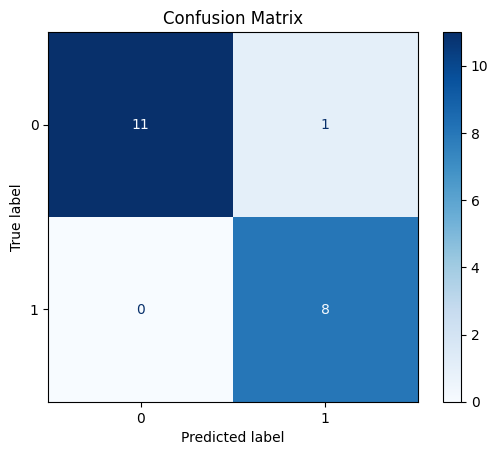

In [18]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
from matplotlib import pyplot as plt

cm = confusion_matrix(qy_test, y_pred)
disp = ConfusionMatrixDisplay(confusion_matrix=cm)
disp.plot(cmap='Blues')
plt.title("Confusion Matrix")
plt.show()